# Library

In [1]:
import math
import random
import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy
from scipy import stats
from pprint import pprint
from collections import Counter
%matplotlib inline
print('Loaded 1')


exec(open('utils.py').read())
print('Loaded 2')

Loaded 1
Loaded 2


In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 100*K                                      # Number of runs to do (default 100*K)
CURRENT_YEAR = 2022                               # What year to start the run on? (default: 2022)
MAX_YEAR = 2222                                   # What year to end the run on? (default: 2100)


years = range(CURRENT_YEAR, MAX_YEAR)
print('Loaded')


Loaded


# Model

### TAI Scenarios

In [3]:
# Conditoinal on making TAI, will it be agentic?
p_make_agent_tai = 0.9

# Conditional on making agentic TAI, will it be aligned by default?
p_tai_aligned_by_default = 0.1

# Conditional on making agentic TAI that is not aligned by default, will we solve the alignment problem?
# Varies by year, whether this is the first attempt, and whether there is a great power war
def p_alignment_solved(war, year, first_attempt=True, verbose=False):
    if first_attempt:
        p = min(0.05 + 1.15 * (year/45), 0.75)
    else:
        p = min(0.05 + 1.5 * (year/45), 0.85)
    if war:
        p = p * 0.7
    if verbose == 2:
        print('* alignment diagnostic - war: {} year: {} first attempt: {} -> p {})'.format(war, year, first_attempt, p))
    return p
# TODO: Convert to logistic curves

# Conditional on solving the alignment problem, what is the chance we also solve the subtle misalignment problem?
p_subtle_alignment_solved = 0.85

# Conditional on alignment by default, what is the chance we also solve the subtle misalignment problem?
p_subtle_alignment_solved_if_aligned_by_default = 0.65

# Conditional on having agentic TAI, will it be intentionally misused to create a singleton?
def p_tai_intentional_misuse(war):
    return 0.3 if war else 0.05

# If TAI is fully misaligned what is the chance we can successfully detect and avert this?
p_full_tai_misalignment_averted = 0.15

# If TAI is fully misaligned but successfully averted, what is the probability there will be a catasrophe (10%+ death)?
p_tai_misalignment_averting_is_catastrophic = 0.4

# If TAI is fully misaligned and we successfully avert it, what is the chance we give up on TAI?
p_full_tai_misalignment_averted_means_abandoned_tai = 0.7

# If TAI is fully misaligned, what is the chance it results in extinction versus a singleton?
p_tai_xrisk_is_extinction = 0.4

# If there is a fully misaligned TAI singleton, what is the chance it results in a non-extinction catastrophe (10%+ death)?
p_tai_singleton_is_catastrophic = 0.8


exec(open('modules/tai.py').read())
print('Loaded TAI scenarios module')


Loaded TAI scenarios module


### Nuclear Scenarios Module

In [4]:
def p_russia_uses_nuke(peace, year):
    peace = 10 if peace else 1
    year = year + CURRENT_YEAR
    if year == 2022 or year == 2023:
        return 0.05 / 2
    else:
        return 0.001 / peace

    
p_nk_uses_nuke = 0.001


def p_china_invades_taiwan(peace, year):
    peace = 10 if peace else 1
    year = year + CURRENT_YEAR
    if year == 2022:
        return 0
    elif year == 2023:
        return 0.03
    elif year == 2024:
        return 0.145 # makes cumulative probability by EOY 2025 = 0.17 (0.03 + 0.145*(1-0.03) = 0.17)
    elif year < 2030:
        return 0.096 # makes cumulative probability by EOY 2029 = 0.5
                     # 0.17 + (1-0.17)*X + (1-0.17)(1-X)*X + (1-0.17)(1-X)^2*X + (1-0.17)(1-X)^3*X + (1-0.17)(1-X)^4*X = 0.5
    elif year < 2035:
        return 0.097 # makes cumulative probability by EOY 2034 = 0.7
                     # 0.5 + (1-0.5)*X + (1-0.5)(1-X)*X + (1-0.5)(1-X)^2*X + (1-0.5)(1-X)^3*X + (1-0.5)(1-X)^4*X = 0.7
    else:
        return 0.005 / peace


def p_china_uses_nuke(peace, year):
    return p_china_invades_taiwan(peace, year) * 0.01

    
def p_other_uses_nuke(peace):
    peace = 10 if peace else 1
    return 0.0002 / peace


# What is the chance in a given year there will be a "nuclear accident"?
def p_nuclear_accident(war, year):
    p = 0.05 if war else 0.02
    p = p * (0.998 ** year)
    return p


# Conditional on a nuclear accident, what is the chance it escalates into an "exchange"?
def p_nuclear_accident_becomes_exchange(war):
    return 0.2 if war else 0.05


# Conditional on a nuclear exchange, what is the chance it escalates into a catastrophe (10%+ dead)?
def p_catastrophe_from_nuclear_exchange(war):
    p_exchange_becomes_all_out_war = 0.6 if war else 0.3
    p_nuclear_winter_happens = 0.3
    alternative_foods_or_other_save = 0.05
    return (p_exchange_becomes_all_out_war *
            (p_nuclear_winter_happens + (1 - p_nuclear_winter_happens) * 0.1) *
            (1 - alternative_foods_or_other_save))
    
    
# Conditional on a nuclear exchange catastrophe, what is the chance it becomes an xrisk?
p_xrisk_from_nuclear_catastrophe = 0.05 # https://forum.effectivealtruism.org/posts/GsjmufaebreiaivF7/what-is-the-likelihood-that-civilizational-collapse-would


# Conditional on a great power war, what is the chance it goes intentionally nuclear in any given year?
def p_nuclear_exchange_given_war(first_year_of_war):
    return 0.1 if first_year_of_war else 0.02


exec(open('modules/nuclear.py').read())
print('Loaded nuclear scenarios module')


Loaded nuclear scenarios module


### Great Power War Scenarios Module

In [5]:
def p_great_power_war_us_russia_without_nuke_first(peace, year):
    peace = 20 if peace else 1
    year = year + CURRENT_YEAR
    if year == 2022 or year == 2023:
        return (0.02 / 2) / peace
    else:
        return 0.003 / peace

    
def p_great_power_war_us_china(peace, year):
    peace = 20 if peace else 1
    p_invade_taiwan = p_china_invades_taiwan(peace, year)
    p_us_responds = 0.6
    return p_invade_taiwan * p_us_responds

    
def p_great_power_war_other(peace, year):
    peace = 5 if peace else 1
    year = year + CURRENT_YEAR
    if year > 2040:
        return 0.005 / peace
    else:
        return 0.001 / peace


# Conditional on a great power war starting, how long will it last?
war_length = sq.lognorm(2, 50) # 90% CI

# After a war ends, how long will there be a peace?
peace_length = sq.lognorm(10, 100)


exec(open('modules/great_power_war.py').read())
print('Loaded great power war scenarios module')


Loaded great power war scenarios module


### Bio scenarios module

In [6]:
# Conditional on a great power war, what is the annual chance it intentionally results in a bioweapon?
p_biowar_given_war = 1/800

# What is the annual chance of a non-state actor creating an intentional biorisk that causes 1%+ death?
p_nonstate_bio = 1/1200

# What is the chance that if 1%+ die from natural bio, 10%+ will die from natural bio?
p_natural_bio_is_catastrophe = 1 / (10 ** 0.5) # https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028

# What is the chance that if 1%+ die from engineered bio, 10%+ will die from engineered bio?
p_engineered_bio_is_catastrophe = 1 / (10 ** 0.5) # https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028

p_covid_spanish_flu_like_becomes_1pct_death = 1 / (10 ** 0.5) # https://www.economist.com/graphic-detail/coronavirus-excess-deaths-estimates suggests COVID killed 0.2%... https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028 suggests 1% is 2x less likely than 0.2%
p_covid_lab_leak = 0.3
p_extinction_given_90_pct_death = 0.03 # per Luisa https://forum.effectivealtruism.org/posts/GsjmufaebreiaivF7/what-is-the-likelihood-that-civilizational-collapse-would
p_accidental_catastrophe_causes_90_pct_death = (1 / (10 ** 0.5)) ** 2 # https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028
p_intentional_catastrophe_causes_90_pct_death = (1 / (10 ** 0.5)) ** 2 # https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028

# If a lab leak occurs, how likely is it that the leaked pandemic will be engineered vs. natural?
ratio_engineered_vs_natural_lab_leak = 0.8

# What is the chance of an natural biorisk/pandemic causing 1%+ population death?
def p_natural_bio(year):
    base_rate_from_covid_and_spanish_flu = 1/250
    increase_from_globalization = 1.1
    decreate_in_rate_per_year_from_improvements = 0.99 ** year
    return ((base_rate_from_covid_and_spanish_flu * 0.5 +
             base_rate_from_covid_and_spanish_flu * (1 - p_covid_lab_leak) * 0.5) *
            increase_from_globalization *
            p_covid_spanish_flu_like_becomes_1pct_death *
            decreate_in_rate_per_year_from_improvements)
    
    
# What is the chance of an accidental biorisk (e.g., lab leak) causing 1%+ population death?
def p_accidental_bio(war):
    base_rate_from_covid = 0.01 * p_covid_lab_leak
    increase_factor_due_to_increasing_labs = 1.3
    increase_factor_due_to_great_power_war = 2
    p = (base_rate_from_covid *
         p_covid_spanish_flu_like_becomes_1pct_death *
         increase_factor_due_to_increasing_labs)
    return p * increase_factor_due_to_great_power_war if war else p
    

# Conditional on a accidental biorisk (1% death), what is the chance it becomes a xrisk?
def p_xrisk_from_accidental_bio_given_catastrophe(year):
    return p_accidental_catastrophe_causes_90_pct_death * p_extinction_given_90_pct_death


# Conditional on a bioweapon, what is the chance it becomes a xrisk?
def p_xrisk_from_engineered_bio_given_catastrophe(year):
    return p_intentional_catastrophe_causes_90_pct_death * p_extinction_given_90_pct_death


exec(open('modules/bio.py').read())
print('Loaded bio scenarios module')


Loaded bio scenarios module


### Nanotech scenarios module

In [7]:
# What is the chance in a given year that nanotech will be developed?
def p_nanotech_possible(year):
    return 0.0001 / (0.956 ** year) # TODO: This goes over 1


# Conditional on developing nanotech, what is the chance nanotech results in an xrisk?
p_nanotech_is_xrisk = 0.1 * 0.05


exec(open('modules/nano.py').read())
print('Loaded nano scenarios module')


Loaded nano scenarios module


### Supervolcano scenarios module (all other natural risks <0.01%)

In [8]:
p_supervolcano_catastrophe = 1 / (500*K)  # https://www.openphilanthropy.org/research/large-volcanic-eruptions/ VEI >= 9 (geometric mean of 30K and 30M)

p_supervolcano_extinction_given_catastrophe = 0.05


exec(open('modules/supervolcano.py').read())
print('Loaded supervolcano module')


Loaded supervolcano module


### Unknown unknown scenarios module

In [9]:
# What is the chance in any given year that an unknown unknown xrisk occurs?
def p_unknown_unknown_xrisk(year):
    return (1 / (100*K)) / (0.99 ** year) # TODO: This goes over 1


p_extinction_from_double_catastrophe = 0.1
extinction_from_double_catastrophe_range = 10
    
    
exec(open('modules/unknown_unknown.py').read())
print('Loaded unknown unknown scenarios module')


Loaded unknown unknown scenarios module


### AI Timeline variables

In [10]:
## AI TIMELINE VARIABLES

def sample_tai_log_flop_needs(brain, efficiency, transformative_vs_human, horizon_length, scaling_exponent,
                              flops_per_param_per_sec, params=None, ref_params=11.2, ref_params_samples=12,
                              bayes_update=None, debug=False):
    # Debug = 1 for just printing parameters
    # Debug = 2 for just printing the equation
    # Debug = True or debug = 3 for printing both
    
    if bayes_update is None:
        bayes_update = lambda x: x
    
    brain_ = sq.sample(brain)
    eff_ = sq.sample(efficiency)
    tvh_ = sq.sample(transformative_vs_human)
    h_ = sq.sample(horizon_length)
    e_ = sq.sample(scaling_exponent)
    fpp_ = sq.sample(flops_per_param_per_sec)
    
    if debug is True or debug == 1 or debug == 2 or debug == 3:
        print('Anchor debug:')
        
    if debug is True or debug == 1 or debug == 3:
        print('-- Assume human brain in inference takes {} log FLOP (i.e., 10^{} FLOP)'.format(round(brain_, 1),
                                                                                               round(brain_, 1)))
        print('-- Add {} log FLOP for efficiency'.format(round(eff_, 1)))
        print('-- Assume a transformative model takes {} log FLOP compared to human'.format(round(tvh_, 1)))
        print('-- Assume a horizon length of {}'.format(round(h_, 1)))
        print('-- Assume a scaling exponent of {}'.format(round(e_, 3)))
        print('-- Assume FLOPs per param per sec of {}'.format(round(fpp_, 1)))
    
    if params is None:
        params_ = brain_ + eff_ - fpp_        
    else:
        params_ = ~params
    
    out = brain_ + eff_ + tvh_ + h_ + ref_params_samples - e_ * ref_params + e_ * params_
    
    if debug is True or debug == 2 or debug == 3:
        if params is None:
            print(f"-- {round(out, 1)} = {round(brain_, 1)} + {round(eff_, 1)} + {round(tvh_, 1)} + {round(h_, 1)} + {ref_params_samples} - {round(e_, 3)} * {ref_params} + {round(e_, 3)} * ({round(brain_, 1)} + {round(eff_, 1)} - {round(fpp_, 1)})")
        else:
            print(f"-- {round(out, 1)} = {round(brain_, 1)} + {round(eff_, 1)} + {round(tvh_, 1)} + {round(h_, 1)} + {ref_params_samples} - {round(e_, 3)} * {ref_params} + {round(e_, 3)} * {round(params_, 2)}")
    
    out = bayes_update(out)
    if debug is True or debug == 2 or debug == 3:
        print('-- {} after Bayes update'.format(round(out, 1)))
    if debug is True or debug == 1 or debug == 2 or debug == 3:
        print('-')

    return out


def wildeford_bayes_update_against_low_flop(f):
    f = f + sq.norm(1,3) if f < 27 and sq.event(p=0.1) else f
    f = f + sq.norm(1,3) if f < 26 and sq.event(p=0.2) else f
    f = f + sq.norm(1,3) if f < 25 and sq.event(p=0.6) else f
    f = f + sq.norm(1,3) if f < 24 and sq.event(p=0.8) else f
    return sq.sample(f)


def wildeford_meta_anchor(efficiency, debug=False):
    horizon_length = sq.mixture([[0.4, 0],
                                 [0.2, sq.norm(0,3)],
                                 [0.25, sq.lognorm(3,7)],
                                 [0.15, sq.norm(7,11)]],
                                lclip=0)
    
    return sample_tai_log_flop_needs(brain=sq.lognorm(11,19.5),
                                     efficiency=efficiency,
                                     transformative_vs_human=sq.norm(-2,1),
                                     horizon_length=horizon_length,
                                     scaling_exponent=sq.norm(0.5,1.5),
                                     flops_per_param_per_sec=sq.norm(1,2),
                                     bayes_update=wildeford_bayes_update_against_low_flop,
                                     debug=debug)


def max_gdp_frac(war):
    small_project = sq.lognorm(1 / (250*K), 1 / (3*K))
    modern_megaproject = sq.lognorm(1/K, 1/600)
    old_form_megaproject = sq.lognorm(1/500, 1/150)
    gigaproject = sq.lognorm(1/150, 1/50)
    
    r_ = random.random()
    if (not war and r_ < 0.3) or (war and r_ < 0.05):
        gdp_frac = small_project
        percent_spent_on_compute = sq.lognorm(0.2,0.6, lclip=0.1, rclip=0.9)
    elif (not war and r_ < 0.9) or (war and r_ < 0.4):
        gdp_frac = modern_megaproject
        percent_spent_on_compute = sq.lognorm(0.4,0.7, lclip=0.1, rclip=0.9)
    elif not war or (war and r_ < 0.9):
        gdp_frac = old_form_megaproject
        percent_spent_on_compute = sq.lognorm(0.5,0.9, lclip=0.1, rclip=0.9)
    else:
        gdp_frac = gigaproject
        percent_spent_on_compute = sq.lognorm(0.6,0.9, lclip=0.1, rclip=0.9)
        
    return gdp_frac * percent_spent_on_compute


initial_gdp = 21.3*T

initial_flops_per_dollar = 18

tai_flop_size = wildeford_meta_anchor

flops_halving_rate = sq.lognorm(2, 5)

initial_pay = sq.mixture([[0.8, 7.1],
                          [0.2, sq.lognorm(7.1,9, lclip=7.1)]])

max_flops_per_dollar = 24

gdp_growth = sq.lognorm(1.015, 1.035) #NEW

spend_doubling_time = sq.mixture([[0.8, sq.lognorm(3,6)],
                                  [0.2, sq.lognorm(1,2, lclip=1)]])
# TODO: Willingness to spend connected to commercialization

initial_chance_of_nonscaling_issue = 0.95
final_chance_of_nonscaling_issue = 0.3 #NEW
nonscaling_issue_bottom_year = 2050
nonscaling_delay = sq.mixture([[0.7, sq.lognorm(2,10)],
                               [0.3, sq.lognorm(5,40)]]) #NEW

algo_doubling_rate_max = sq.norm(1,3) # NEW
algo_doubling_rate_min = sq.norm(1,2) # NEW

efficiency = sq.mixture([[0.1, 0],
                          [0.9, sq.lognorm(1,4)]])

use_efficiency_based_algo_reduction = True
efficiency_based_additional_reduction = sq.mixture([[0.4, 0],
                                                    [0.6, sq.norm(0,2)]]) # NEW

p_willingness_ramp = 0

willingness_spend_horizon = 1

tai_china_war_delay_yrs = sq.norm(2,6)
tai_china_war_delay_end_year = 2040

tai_catastrophe_delay_yrs = sq.lognorm(4,20)

# These equations define how variables change over time or in relationship to other variables.
def gdp(initial_gdp, gdp_growth, year):
    return initial_gdp * (gdp_growth ** year)


def willingness_to_pay(initial_gdp, gdp_growth, initial_pay, spend_doubling_time, max_gdp_frac, year):
    gdp_ = gdp(initial_gdp=initial_gdp, gdp_growth=gdp_growth, year=year)
    x = (np.log(2) / spend_doubling_time) * year
    if x < 650:
        y = math.log10(initial_pay) + math.log10(math.exp(x)) - math.log10(1 + initial_pay / (gdp_ * max_gdp_frac) * math.exp(x))
        if y > 300:
            y = int(y) # Handle overflow errors
        return 10 ** y
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_pay) + (year/spend_doubling_time)/3.3)
    

def algo_halving_fn(min_speed, max_speed, tai_flop_size):
    if max_speed < min_speed:
        max_speed = min_speed
    if min_speed > max_speed:
        min_speed = max_speed
    return min(max(max_speed - (round((tai_flop_size - 29) / 2) / 2), min_speed), max_speed)


def flops_needed(initial_flops, possible_reduction, doubling_rate, year):
    x = (np.log(2) / doubling_rate) * year
    if x < 650:
        y = (math.log10(initial_flops) - max(math.log10(math.exp(x)) - math.log10(1 + (1/possible_reduction) * math.exp(x)), 0))
        if y > 300:
            y = int(y) # Handle overflow errors        
        return 10 ** y
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_flops) - (1/possible_reduction))

    
def flops_per_dollar(initial_flops_per_dollar, max_flops_per_dollar, halving_rate, year):
    x = (np.log(2) / halving_rate) * year
    if x < 650:
        y = (math.log10(initial_flops_per_dollar) + math.log10(math.exp(x)) - math.log10(1 + initial_flops_per_dollar / max_flops_per_dollar * math.exp(x)))
        if y > 300:
            y = int(y) # Handle overflow errors                
        return 10 ** y
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_flops_per_dollar) + (year/halving_rate)/3.3)

    
def cost_of_tai(initial_flops, possible_reduction, algo_doubling_rate, initial_flops_per_dollar, max_flops_per_dollar,
                flops_halving_rate, year):
    return (flops_needed(initial_flops, possible_reduction, algo_doubling_rate, year) /
            flops_per_dollar(initial_flops_per_dollar, max_flops_per_dollar, flops_halving_rate, year))


def possible_algo_reduction_fn(min_reduction, max_reduction, tai_flop_size):
    if max_reduction < min_reduction:
        max_reduction = min_reduction
    if min_reduction > max_reduction:
        min_reduction = max_reduction
    return min(max(min_reduction + round((tai_flop_size - 32) / 4), min_reduction), max_reduction)


# NEW
def p_nonscaling_delay(initial_p, final_p, year, max_year):
    return generalized_logistic_curve(x=year - CURRENT_YEAR,
                                      slope=0.3,
                                      shift=3 * (max_year - CURRENT_YEAR),
                                      push=1,
                                      maximum=final_p,
                                      minimum=initial_p)


print('Loaded')


Loaded


### Overall module structure

In [11]:
sq.get_percentiles(max_gdp_frac(war=True) @ 1000)

{1: 0.0009631598605587303,
 5: 0.0012346049134214598,
 10: 0.0014830730273648408,
 20: 0.001762916247327276,
 30: 0.001993387976856,
 40: 0.002240886168080721,
 50: 0.0024748672673169814,
 60: 0.002743281400848854,
 70: 0.0030257481279837716,
 80: 0.0034838260042717012,
 90: 0.00408791119847807,
 95: 0.00482843067277772,
 99: 0.006187053564957021}

In [12]:
sq.get_percentiles(max_gdp_frac(war=False) @ 1000)

{1: 0.0010183616505510542,
 5: 0.001231846399342236,
 10: 0.0014511043307591674,
 20: 0.0017577427688523926,
 30: 0.0020324817398636895,
 40: 0.0022408206552591505,
 50: 0.0024941987674056637,
 60: 0.0027223530515263854,
 70: 0.0030258793972154233,
 80: 0.003434458204610346,
 90: 0.0041388334868645805,
 95: 0.004787727997860831,
 99: 0.006118291746004227}

In [13]:
sq.get_percentiles([int(round(x)) for x in tai_china_war_delay_yrs @ 1000])

{1: 1.0,
 5: 2.0,
 10: 2.0,
 20: 3.0,
 30: 3.0,
 40: 4.0,
 50: 4.0,
 60: 4.0,
 70: 5.0,
 80: 5.0,
 90: 6.0,
 95: 6.0,
 99: 7.0}

In [14]:
sq.get_percentiles([int(round(x)) for x in tai_catastrophe_delay_yrs @ 1000])

{1: 3.0,
 5: 4.0,
 10: 5.0,
 20: 6.0,
 30: 7.0,
 40: 8.0,
 50: 9.0,
 60: 10.0,
 70: 11.0,
 80: 13.0,
 90: 17.0,
 95: 19.049999999999955,
 99: 26.00999999999999}

In [15]:
exec(open('modules/define_event.py').read())
print('Model loaded')


Model loaded


Anchor debug:
-- Assume human brain in inference takes 10.8 log FLOP (i.e., 10^10.8 FLOP)
-- Add 1.4 log FLOP for efficiency
-- Assume a transformative model takes 0.0 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.55
-- Assume FLOPs per param per sec of 1.3
-- 24.0 = 10.8 + 1.4 + 0.0 + 0 + 12 - 0.55 * 11.2 + 0.55 * (10.8 + 1.4 - 1.3)
-- 24.0 after Bayes update
-
...TAI setup complete in 4.48ms
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 24.0 log FLOPs (~1 septillion) for transformative capabilities.
Every 2.7 years algorithms get 2x better, with 1.4 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 1.1x per year to a max of 0.00077% of GDP. GDP grows at a rate of 1.027x per year.
If a non-scaling 

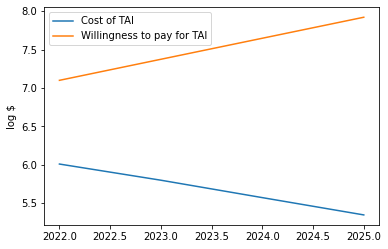

2025: ...XRISK from fully unaligned TAI (singleton) :(
...Singleton is catastrophic
...Total loop complete in 128.64ms
-
-
{'collectors': {2022: {'averted_misalignment': False,
                       'catastrophe': [],
                       'category': 'boring',
                       'china_nuke_first': False,
                       'double_catastrophe_xrisk': None,
                       'engineered_pathogen': False,
                       'final_year': None,
                       'lab_leak': False,
                       'nano': False,
                       'natural_pathogen': False,
                       'nonstate_bioweapon': False,
                       'nuclear_weapon_used': False,
                       'peace_until': None,
                       'recent_catastrophe_year': None,
                       'russia_nuke_first': False,
                       'state_bioweapon': False,
                       'tai': False,
                       'tai_type': None,
                    

                       'war_belligerents': None,
                       'war_end_year': None,
                       'war_start_year': None,
                       'wars': []},
                2112: {'averted_misalignment': False,
                       'catastrophe': ['xrisk_full_unaligned_tai_singleton'],
                       'category': 'xrisk_full_unaligned_tai_singleton',
                       'china_nuke_first': False,
                       'double_catastrophe_xrisk': None,
                       'engineered_pathogen': False,
                       'final_year': 2025,
                       'lab_leak': False,
                       'nano': False,
                       'natural_pathogen': False,
                       'nonstate_bioweapon': False,
                       'nuclear_weapon_used': False,
                       'peace_until': None,
                       'recent_catastrophe_year': None,
                       'russia_nuke_first': False,
                       'state

In [16]:
pprint(define_event(verbosity=4))

2148: North Korea uses a nuke first strike!
...Boring future


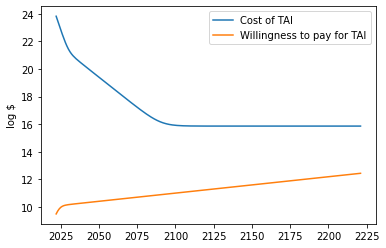

-
-


In [17]:
define_event(verbosity=1); None

-
-
############
## RUN 1 ##
############
Anchor debug:
-- Assume human brain in inference takes 16.6 log FLOP (i.e., 10^16.6 FLOP)
-- Add 2.7 log FLOP for efficiency
-- Assume a transformative model takes -0.9 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.211
-- Assume FLOPs per param per sec of 1.9
-- 37.8 = 16.6 + 2.7 + -0.9 + 0 + 12 - 1.211 * 11.2 + 1.211 * (16.6 + 2.7 - 1.9)
-- 37.8 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 37.8 log FLOPs (~68 thousand decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3.9 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.1 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 4.7x per year to a max of 0.00071% of GDP. GDP grows at a rate of 1.025x per

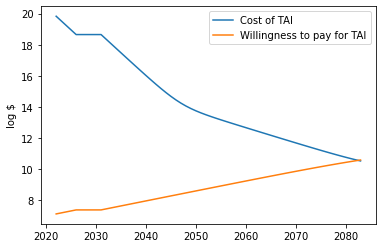

2083: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 2 ##
############
Anchor debug:
-- Assume human brain in inference takes 13.0 log FLOP (i.e., 10^13.0 FLOP)
-- Add 3.5 log FLOP for efficiency
-- Assume a transformative model takes -2.5 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.021
-- Assume FLOPs per param per sec of 1.8
-- 29.6 = 13.0 + 3.5 + -2.5 + 0 + 12 - 1.021 * 11.2 + 1.021 * (13.0 + 3.5 - 1.8)
-- 29.6 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 29.6 log FLOPs (~360 octillion) for transformative capabilities.
Every 3.1 years algorithms get 2x better, with 4.1 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.7 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases b

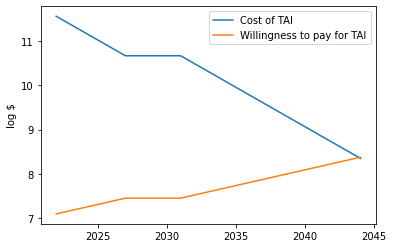

2044: ...Tool TAI made
2046: War ends :)
2066: ...catastrophe from lab-leak engineered pathogen
2077: WAR!!! (Other)
2079: War ends :)
2180: ...XRISK from unknown unknown
-
-
-
-
############
## RUN 3 ##
############
Anchor debug:
-- Assume human brain in inference takes 11.3 log FLOP (i.e., 10^11.3 FLOP)
-- Add 3.0 log FLOP for efficiency
-- Assume a transformative model takes -2.0 log FLOP compared to human
-- Assume a horizon length of 1.3
-- Assume a scaling exponent of 1.298
-- Assume FLOPs per param per sec of 1.8
-- 27.1 = 11.3 + 3.0 + -2.0 + 1.3 + 12 - 1.298 * 11.2 + 1.298 * (11.3 + 3.0 - 1.8)
-- 27.1 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 27.1 log FLOPs (~1 octillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 3.0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 5.0 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septilli

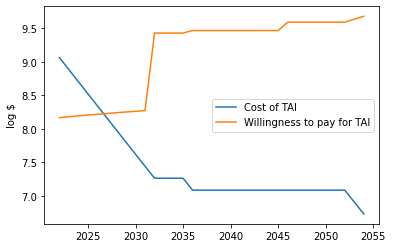

2054: ...XRISK from fully unaligned TAI (singleton) :(
...Singleton is catastrophic
-
-
-
-
############
## RUN 4 ##
############
Anchor debug:
-- Assume human brain in inference takes 14.4 log FLOP (i.e., 10^14.4 FLOP)
-- Add 3.4 log FLOP for efficiency
-- Assume a transformative model takes -2.7 log FLOP compared to human
-- Assume a horizon length of 4.2
-- Assume a scaling exponent of 1.032
-- Assume FLOPs per param per sec of 1.8
-- 36.3 = 14.4 + 3.4 + -2.7 + 4.2 + 12 - 1.032 * 11.2 + 1.032 * (14.4 + 3.4 - 1.8)
-- 36.3 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 36.3 log FLOPs (~2 thousand decillion) for transformative capabilities.
Every 1.7 years algorithms get 2x better, with 3.4 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and thi

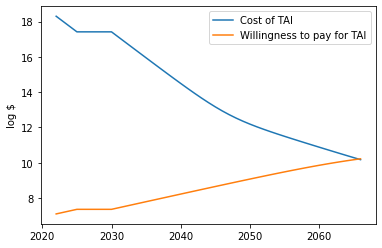

2066: ...Tool TAI made
2106: Russia uses a nuke first strike (outside of great power war)!
2107: WAR!!! (US vs. Russia)
2129: War ends :)
2160: WAR!!! (Other)
2166: War ends :)
...Boring future
-
-
-
-
############
## RUN 5 ##
############
Anchor debug:
-- Assume human brain in inference takes 16.3 log FLOP (i.e., 10^16.3 FLOP)
-- Add 2.2 log FLOP for efficiency
-- Assume a transformative model takes 0.1 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.434
-- Assume FLOPs per param per sec of 1.4
-- 39.0 = 16.3 + 2.2 + 0.1 + 0 + 12 - 1.434 * 11.2 + 1.434 * (16.3 + 2.2 - 1.4)
-- 39.0 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 39.0 log FLOPs (~1 million decillion) for transformative capabilities.
Every 1.2 years algorithms get 2x better, with 2.2 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 4.7 years they get 2x cheaper, to a maximum of 24

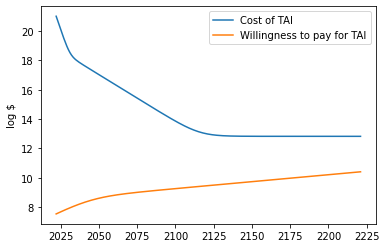

-
-
-
-
############
## RUN 6 ##
############
Anchor debug:
-- Assume human brain in inference takes 16.0 log FLOP (i.e., 10^16.0 FLOP)
-- Add 1.9 log FLOP for efficiency
-- Assume a transformative model takes -0.3 log FLOP compared to human
-- Assume a horizon length of 8.5
-- Assume a scaling exponent of 0.975
-- Assume FLOPs per param per sec of 1.8
-- 42.9 = 16.0 + 1.9 + -0.3 + 8.5 + 12 - 0.975 * 11.2 + 0.975 * (16.0 + 1.9 - 1.8)
-- 42.9 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 42.9 log FLOPs (~7 billion decillion) for transformative capabilities.
Every 1.8 years algorithms get 2x better, with 1.9 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 4.7x per year to a max of 0.00075% of GDP. GDP grows at a rate of 1.03

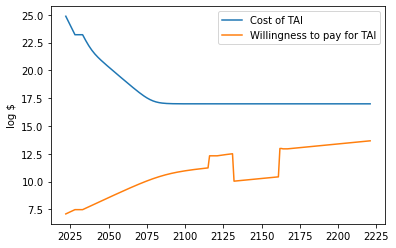

-
-
-
-
############
## RUN 7 ##
############
Anchor debug:
-- Assume human brain in inference takes 13.6 log FLOP (i.e., 10^13.6 FLOP)
-- Add 5.0 log FLOP for efficiency
-- Assume a transformative model takes 0.2 log FLOP compared to human
-- Assume a horizon length of 1.2
-- Assume a scaling exponent of 0.902
-- Assume FLOPs per param per sec of 1.4
-- 37.4 = 13.6 + 5.0 + 0.2 + 1.2 + 12 - 0.902 * 11.2 + 0.902 * (13.6 + 5.0 - 1.4)
-- 37.4 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 37.4 log FLOPs (~24 thousand decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 6.1 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.6 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 4.3x per year to a max of 0.00071% of GDP. GDP grows at a rate of 1.02

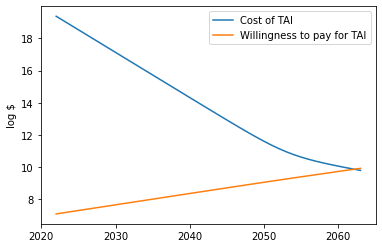

2063: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 8 ##
############
Anchor debug:
-- Assume human brain in inference takes 13.8 log FLOP (i.e., 10^13.8 FLOP)
-- Add 0 log FLOP for efficiency
-- Assume a transformative model takes -1.9 log FLOP compared to human
-- Assume a horizon length of 1.8
-- Assume a scaling exponent of 0.961
-- Assume FLOPs per param per sec of 1.8
-- 26.5 = 13.8 + 0 + -1.9 + 1.8 + 12 - 0.961 * 11.2 + 0.961 * (13.8 + 0 - 1.8)
-- 26.5 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 26.5 log FLOPs (~287 septillion) for transformative capabilities.
Every 1.8 years algorithms get 2x better, with 0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.9 log 2022$USD (~88 million) and this increases by 3

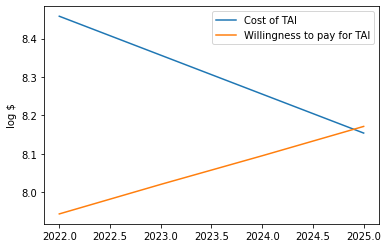

2025: ...XRISK from intentional misuse of TAI (singleton) :(
...Singleton is catastrophic
-
-
-
-
############
## RUN 9 ##
############
Anchor debug:
-- Assume human brain in inference takes 12.9 log FLOP (i.e., 10^12.9 FLOP)
-- Add 0 log FLOP for efficiency
-- Assume a transformative model takes -0.7 log FLOP compared to human
-- Assume a horizon length of 2.0
-- Assume a scaling exponent of 1.262
-- Assume FLOPs per param per sec of 1.6
-- 26.4 = 12.9 + 0 + -0.7 + 2.0 + 12 - 1.262 * 11.2 + 1.262 * (12.9 + 0 - 1.6)
-- 26.4 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 26.4 log FLOPs (~257 septillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 0.6 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this incr

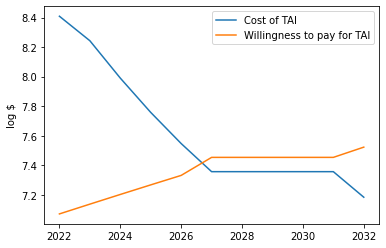

2032: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 10 ##
############
Anchor debug:
-- Assume human brain in inference takes 17.1 log FLOP (i.e., 10^17.1 FLOP)
-- Add 4.1 log FLOP for efficiency
-- Assume a transformative model takes -1.2 log FLOP compared to human
-- Assume a horizon length of 9.7
-- Assume a scaling exponent of 0.89
-- Assume FLOPs per param per sec of 1.7
-- 49.1 = 17.1 + 4.1 + -1.2 + 9.7 + 12 - 0.89 * 11.2 + 0.89 * (17.1 + 4.1 - 1.7)
-- 49.1 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 49.1 log FLOPs (~12 quadrillion decillion) for transformative capabilities.
Every 1.2 years algorithms get 2x better, with 4.5 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 4.6 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and thi

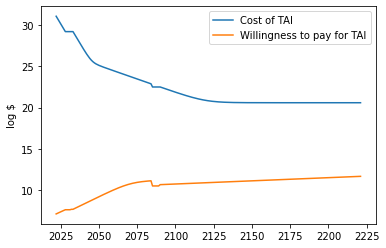

-
-
-
-
############
## RUN 11 ##
############
Anchor debug:
-- Assume human brain in inference takes 14.2 log FLOP (i.e., 10^14.2 FLOP)
-- Add 2.6 log FLOP for efficiency
-- Assume a transformative model takes -0.2 log FLOP compared to human
-- Assume a horizon length of 2.4
-- Assume a scaling exponent of 0.64
-- Assume FLOPs per param per sec of 1.5
-- 33.6 = 14.2 + 2.6 + -0.2 + 2.4 + 12 - 0.64 * 11.2 + 0.64 * (14.2 + 2.6 - 1.5)
-- 33.6 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 33.6 log FLOPs (~4 decillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 4.0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.1 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 1.2x per year to a max of 0.00085% of GDP. GDP grows at a rate of 1.027x per yea

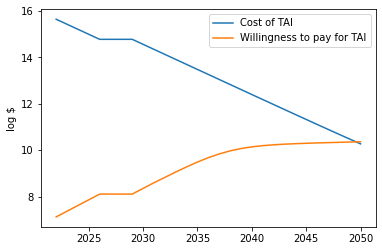

2050: ...XRISK from fully unaligned TAI (singleton) :(
...Singleton is catastrophic
-
-
-
-
############
## RUN 12 ##
############
Anchor debug:
-- Assume human brain in inference takes 12.1 log FLOP (i.e., 10^12.1 FLOP)
-- Add 1.5 log FLOP for efficiency
-- Assume a transformative model takes 0.2 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.957
-- Assume FLOPs per param per sec of 1.0
-- 27.0 = 12.1 + 1.5 + 0.2 + 0 + 12 - 0.957 * 11.2 + 0.957 * (12.1 + 1.5 - 1.0)
-- 27.0 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 27.0 log FLOPs (~1 octillion) for transformative capabilities.
Every 1.9 years algorithms get 2x better, with 2.4 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.3 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by

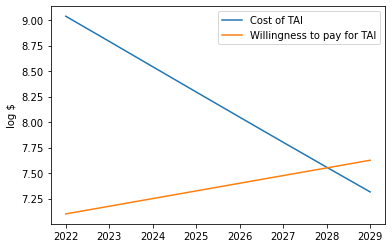

2029: ...Misaligned TAI happened, it was averted with no catastrophe, and we abandon TAI
2046: North Korea uses a nuke first strike!
2070: WAR!!! (Other)
2100: War ends :)
...Boring future
-
-
-
-
############
## RUN 13 ##
############
Anchor debug:
-- Assume human brain in inference takes 13.8 log FLOP (i.e., 10^13.8 FLOP)
-- Add 0 log FLOP for efficiency
-- Assume a transformative model takes -0.9 log FLOP compared to human
-- Assume a horizon length of 3.3
-- Assume a scaling exponent of 0.834
-- Assume FLOPs per param per sec of 1.6
-- 29.1 = 13.8 + 0 + -0.9 + 3.3 + 12 - 0.834 * 11.2 + 0.834 * (13.8 + 0 - 1.6)
-- 29.1 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 29.1 log FLOPs (~130 octillion) for transformative capabilities.
Every 2.6 years algorithms get 2x better, with 0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.6 years they get 2x cheaper, to a maximum of 24.0 log FLOPs

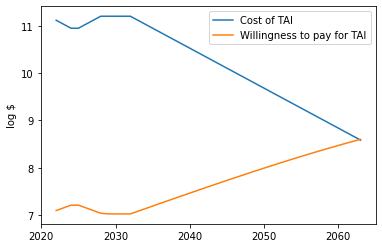

2063: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 14 ##
############
Anchor debug:
-- Assume human brain in inference takes 14.1 log FLOP (i.e., 10^14.1 FLOP)
-- Add 2.5 log FLOP for efficiency
-- Assume a transformative model takes -0.6 log FLOP compared to human
-- Assume a horizon length of 9.0
-- Assume a scaling exponent of 0.955
-- Assume FLOPs per param per sec of 1.9
-- 40.3 = 14.1 + 2.5 + -0.6 + 9.0 + 12 - 0.955 * 11.2 + 0.955 * (14.1 + 2.5 - 1.9)
-- 40.3 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 40.3 log FLOPs (~22 million decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 2.5 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this

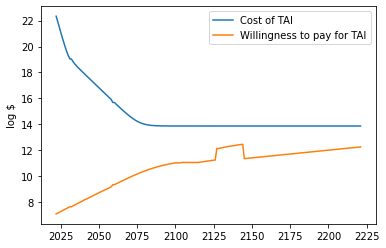

-
-
-
-
############
## RUN 15 ##
############
Anchor debug:
-- Assume human brain in inference takes 14.2 log FLOP (i.e., 10^14.2 FLOP)
-- Add 3.2 log FLOP for efficiency
-- Assume a transformative model takes 0.8 log FLOP compared to human
-- Assume a horizon length of 5.1
-- Assume a scaling exponent of 0.814
-- Assume FLOPs per param per sec of 1.4
-- 39.2 = 14.2 + 3.2 + 0.8 + 5.1 + 12 - 0.814 * 11.2 + 0.814 * (14.2 + 3.2 - 1.4)
-- 39.2 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 39.2 log FLOPs (~2 million decillion) for transformative capabilities.
Every 1.1 years algorithms get 2x better, with 3.1 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 4.0 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 3.6x per year to a max of 0.00065% of GDP. GDP grows at a rate of 1.03x

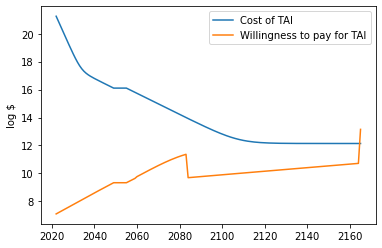

2165: ...XRISK from fully unaligned TAI (singleton) :(
...Singleton is catastrophic
-
-
-
-
############
## RUN 16 ##
############
Anchor debug:
-- Assume human brain in inference takes 12.4 log FLOP (i.e., 10^12.4 FLOP)
-- Add 2.0 log FLOP for efficiency
-- Assume a transformative model takes -1.7 log FLOP compared to human
-- Assume a horizon length of 1.1
-- Assume a scaling exponent of 1.178
-- Assume FLOPs per param per sec of 1.5
-- 27.8 = 12.4 + 2.0 + -1.7 + 1.1 + 12 - 1.178 * 11.2 + 1.178 * (12.4 + 2.0 - 1.5)
-- 27.8 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 27.8 log FLOPs (~6 octillion) for transformative capabilities.
Every 3.4 years algorithms get 2x better, with 1.8 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increa

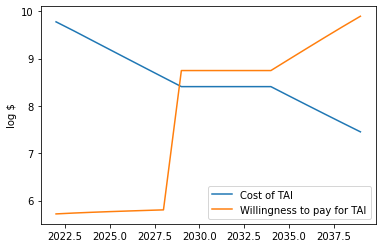

2039: ...Tool TAI made
2083: War ends :)
...Boring future
-
-
-
-
############
## RUN 17 ##
############
Anchor debug:
-- Assume human brain in inference takes 22.7 log FLOP (i.e., 10^22.7 FLOP)
-- Add 1.2 log FLOP for efficiency
-- Assume a transformative model takes -0.2 log FLOP compared to human
-- Assume a horizon length of 9.0
-- Assume a scaling exponent of 1.255
-- Assume FLOPs per param per sec of 1.7
-- 58.6 = 22.7 + 1.2 + -0.2 + 9.0 + 12 - 1.255 * 11.2 + 1.255 * (22.7 + 1.2 - 1.7)
-- 58.6 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 58.6 log FLOPs (~38 septillion decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 1.2 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 1.9 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 8.3 log 2022$USD (~206 million) and this increases by 5.0x p

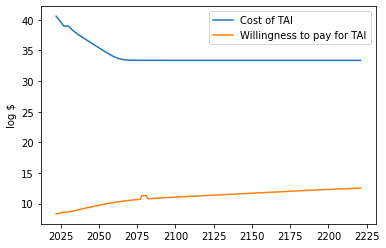

-
-
-
-
############
## RUN 18 ##
############
Anchor debug:
-- Assume human brain in inference takes 17.8 log FLOP (i.e., 10^17.8 FLOP)
-- Add 2.3 log FLOP for efficiency
-- Assume a transformative model takes -1.8 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.297
-- Assume FLOPs per param per sec of 2.2
-- 32.4 = 17.8 + 2.3 + -1.8 + 0 + 12 - 0.297 * 11.2 + 0.297 * (17.8 + 2.3 - 2.2)
-- 32.4 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 32.4 log FLOPs (~252 nonillion) for transformative capabilities.
Every 1.8 years algorithms get 2x better, with 2.7 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 8.3 log 2022$USD (~192 million) and this increases by 5.1x per year to a max of 0.00068% of GDP. GDP grows at a rate of 1.02x per ye

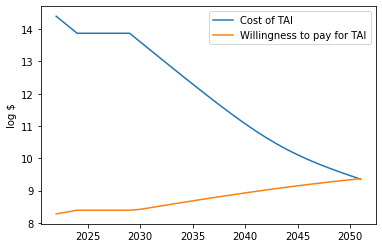

2051: ...XRISK from subtly unaligned TAI :(
-
-
-
-
############
## RUN 19 ##
############
Anchor debug:
-- Assume human brain in inference takes 15.8 log FLOP (i.e., 10^15.8 FLOP)
-- Add 1.9 log FLOP for efficiency
-- Assume a transformative model takes 1.1 log FLOP compared to human
-- Assume a horizon length of 2.4
-- Assume a scaling exponent of 0.5
-- Assume FLOPs per param per sec of 1.2
-- 35.9 = 15.8 + 1.9 + 1.1 + 2.4 + 12 - 0.5 * 11.2 + 0.5 * (15.8 + 1.9 - 1.2)
-- 35.9 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 35.9 log FLOPs (~733 decillion) for transformative capabilities.
Every 1.7 years algorithms get 2x better, with 1.9 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.9 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 3.8x per year to a max of 4e-05% of GDP

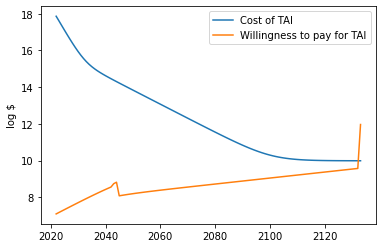

2133: ...XRISK from subtly unaligned TAI :(
-
-
-
-
############
## RUN 20 ##
############
Anchor debug:
-- Assume human brain in inference takes 13.8 log FLOP (i.e., 10^13.8 FLOP)
-- Add 2.9 log FLOP for efficiency
-- Assume a transformative model takes -0.8 log FLOP compared to human
-- Assume a horizon length of 2.3
-- Assume a scaling exponent of 1.355
-- Assume FLOPs per param per sec of 1.5
-- 35.8 = 13.8 + 2.9 + -0.8 + 2.3 + 12 - 1.355 * 11.2 + 1.355 * (13.8 + 2.9 - 1.5)
-- 35.8 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 35.8 log FLOPs (~639 decillion) for transformative capabilities.
Every 1.8 years algorithms get 2x better, with 2.9 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.4 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 8.0 log 2022$USD (~102 million) and this increases by 5.5x per year to a max of 0.00

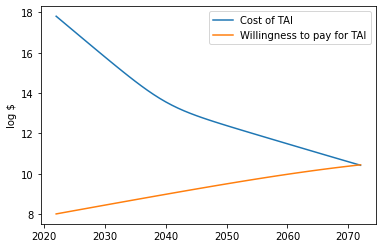

2072: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 21 ##
############
Anchor debug:
-- Assume human brain in inference takes 18.0 log FLOP (i.e., 10^18.0 FLOP)
-- Add 2.9 log FLOP for efficiency
-- Assume a transformative model takes -0.9 log FLOP compared to human
-- Assume a horizon length of 5.5
-- Assume a scaling exponent of 0.609
-- Assume FLOPs per param per sec of 1.4
-- 42.6 = 18.0 + 2.9 + -0.9 + 5.5 + 12 - 0.609 * 11.2 + 0.609 * (18.0 + 2.9 - 1.4)
-- 42.6 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 42.6 log FLOPs (~4 billion decillion) for transformative capabilities.
Every 1.7 years algorithms get 2x better, with 3.8 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this 

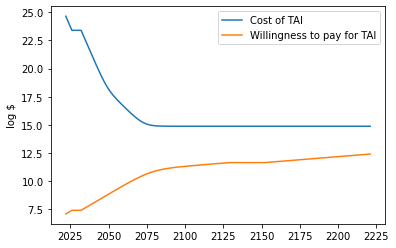

-
-
-
-
############
## RUN 22 ##
############
Anchor debug:
-- Assume human brain in inference takes 16.5 log FLOP (i.e., 10^16.5 FLOP)
-- Add 2.1 log FLOP for efficiency
-- Assume a transformative model takes -0.3 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.411
-- Assume FLOPs per param per sec of 1.4
-- 38.8 = 16.5 + 2.1 + -0.3 + 0 + 12 - 1.411 * 11.2 + 1.411 * (16.5 + 2.1 - 1.4)
-- 38.8 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 38.8 log FLOPs (~565 thousand decillion) for transformative capabilities.
Every 1.2 years algorithms get 2x better, with 2.1 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.1 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 1.6x per year to a max of 2e-05% of GDP. GDP grows at a rate of 1.02x 

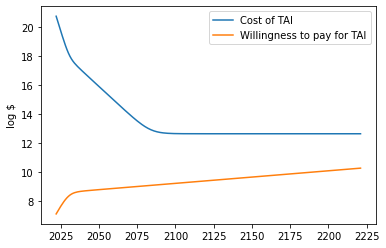

-
-
-
-
############
## RUN 23 ##
############
Anchor debug:
-- Assume human brain in inference takes 14.0 log FLOP (i.e., 10^14.0 FLOP)
-- Add 2.7 log FLOP for efficiency
-- Assume a transformative model takes -0.2 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.206
-- Assume FLOPs per param per sec of 1.2
-- 33.5 = 14.0 + 2.7 + -0.2 + 0 + 12 - 1.206 * 11.2 + 1.206 * (14.0 + 2.7 - 1.2)
-- 33.5 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 33.5 log FLOPs (~3 decillion) for transformative capabilities.
Every 1.3 years algorithms get 2x better, with 3.3 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 3.5x per year to a max of 0.00164% of GDP. GDP grows at a rate of 1.024x per year

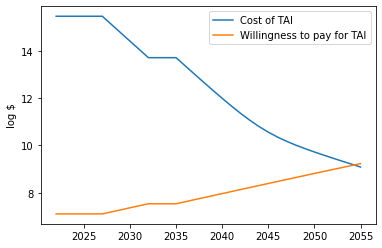

2055: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 24 ##
############
Anchor debug:
-- Assume human brain in inference takes 15.0 log FLOP (i.e., 10^15.0 FLOP)
-- Add 3.1 log FLOP for efficiency
-- Assume a transformative model takes -1.4 log FLOP compared to human
-- Assume a horizon length of 8.1
-- Assume a scaling exponent of 1.129
-- Assume FLOPs per param per sec of 1.5
-- 42.9 = 15.0 + 3.1 + -1.4 + 8.1 + 12 - 1.129 * 11.2 + 1.129 * (15.0 + 3.1 - 1.5)
-- 42.9 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 42.9 log FLOPs (~8 billion decillion) for transformative capabilities.
Every 1.4 years algorithms get 2x better, with 4.8 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.4 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this 

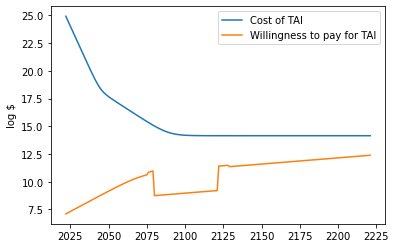

-
-
-
-
############
## RUN 25 ##
############
Anchor debug:
-- Assume human brain in inference takes 15.4 log FLOP (i.e., 10^15.4 FLOP)
-- Add 1.9 log FLOP for efficiency
-- Assume a transformative model takes -1.1 log FLOP compared to human
-- Assume a horizon length of 9.6
-- Assume a scaling exponent of 1.225
-- Assume FLOPs per param per sec of 2.0
-- 42.9 = 15.4 + 1.9 + -1.1 + 9.6 + 12 - 1.225 * 11.2 + 1.225 * (15.4 + 1.9 - 2.0)
-- 42.9 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 42.9 log FLOPs (~8 billion decillion) for transformative capabilities.
Every 1.6 years algorithms get 2x better, with 3.1 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.7 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.6 log 2022$USD (~38 million) and this increases by 4.9x per year to a max of 0.00298% of GDP. GDP grows at a rate of 1.0

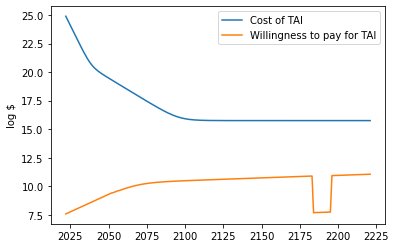

-
-
-
-
############
## RUN 26 ##
############
Anchor debug:
-- Assume human brain in inference takes 16.4 log FLOP (i.e., 10^16.4 FLOP)
-- Add 2.2 log FLOP for efficiency
-- Assume a transformative model takes 1.2 log FLOP compared to human
-- Assume a horizon length of 1.0
-- Assume a scaling exponent of 1.311
-- Assume FLOPs per param per sec of 1.2
-- 40.8 = 16.4 + 2.2 + 1.2 + 1.0 + 12 - 1.311 * 11.2 + 1.311 * (16.4 + 2.2 - 1.2)
-- 40.8 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 40.8 log FLOPs (~61 million decillion) for transformative capabilities.
Every 1.3 years algorithms get 2x better, with 2.2 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 1.5x per year to a max of 0.0% of GDP. GDP grows at a rate of 1.031x p

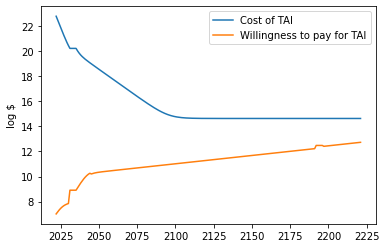

-
-
-
-
############
## RUN 27 ##
############
Anchor debug:
-- Assume human brain in inference takes 16.0 log FLOP (i.e., 10^16.0 FLOP)
-- Add 2.1 log FLOP for efficiency
-- Assume a transformative model takes -0.9 log FLOP compared to human
-- Assume a horizon length of 7.6
-- Assume a scaling exponent of 0.805
-- Assume FLOPs per param per sec of 1.9
-- 41.0 = 16.0 + 2.1 + -0.9 + 7.6 + 12 - 0.805 * 11.2 + 0.805 * (16.0 + 2.1 - 1.9)
-- 41.0 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 41.0 log FLOPs (~96 million decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 2.1 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 3.7x per year to a max of 0.00072% of GDP. GDP grows at a rate of 1.

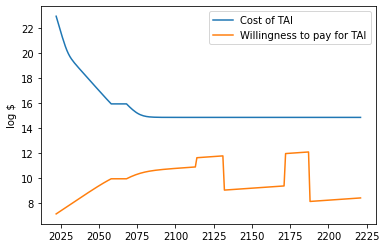

-
-
-
-
############
## RUN 28 ##
############
Anchor debug:
-- Assume human brain in inference takes 14.9 log FLOP (i.e., 10^14.9 FLOP)
-- Add 2.0 log FLOP for efficiency
-- Assume a transformative model takes -0.0 log FLOP compared to human
-- Assume a horizon length of 0.4
-- Assume a scaling exponent of 1.181
-- Assume FLOPs per param per sec of 1.5
-- 34.3 = 14.9 + 2.0 + -0.0 + 0.4 + 12 - 1.181 * 11.2 + 1.181 * (14.9 + 2.0 - 1.5)
-- 34.3 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 34.3 log FLOPs (~20 decillion) for transformative capabilities.
Every 1.4 years algorithms get 2x better, with 2.0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.3 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 5.1x per year to a max of 0.00047% of GDP. GDP grows at a rate of 1.015x per

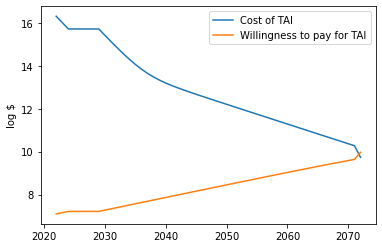

2072: ...Tool TAI made
2078: War ends :)
2112: A country other than Russia/China/NK uses a nuke first strike (outside of great power war)!
2124: ...catastrophe from lab-leak natural pathogen
2156: A country other than Russia/China/NK uses a nuke first strike (outside of great power war)!
...Boring future
-
-
-
-
############
## RUN 29 ##
############
Anchor debug:
-- Assume human brain in inference takes 11.8 log FLOP (i.e., 10^11.8 FLOP)
-- Add 2.3 log FLOP for efficiency
-- Assume a transformative model takes -2.0 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.152
-- Assume FLOPs per param per sec of 1.8
-- 25.3 = 11.8 + 2.3 + -2.0 + 0 + 12 - 1.152 * 11.2 + 1.152 * (11.8 + 2.3 - 1.8)
-- 25.3 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 25.3 log FLOPs (~20 septillion) for transformative capabilities.
Every 1.9 years algorithms get 2x better, with 3.4 log reductions possible.
FLOPs start at a 

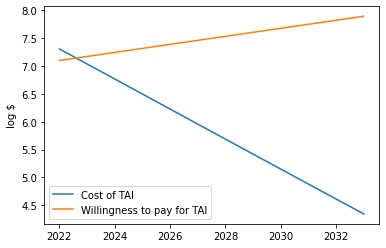

2033: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 30 ##
############
Anchor debug:
-- Assume human brain in inference takes 17.7 log FLOP (i.e., 10^17.7 FLOP)
-- Add 1.8 log FLOP for efficiency
-- Assume a transformative model takes -0.4 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.459
-- Assume FLOPs per param per sec of 1.3
-- 41.3 = 17.7 + 1.8 + -0.4 + 0 + 12 - 1.459 * 11.2 + 1.459 * (17.7 + 1.8 - 1.3)
-- 41.3 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 41.3 log FLOPs (~179 million decillion) for transformative capabilities.
Every 1.2 years algorithms get 2x better, with 2.9 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this in

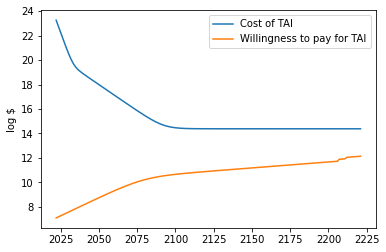

-
-
-
-
############
## RUN 31 ##
############
Anchor debug:
-- Assume human brain in inference takes 13.8 log FLOP (i.e., 10^13.8 FLOP)
-- Add 2.6 log FLOP for efficiency
-- Assume a transformative model takes -1.1 log FLOP compared to human
-- Assume a horizon length of 0.8
-- Assume a scaling exponent of 0.797
-- Assume FLOPs per param per sec of 1.2
-- 31.4 = 13.8 + 2.6 + -1.1 + 0.8 + 12 - 0.797 * 11.2 + 0.797 * (13.8 + 2.6 - 1.2)
-- 31.4 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 31.4 log FLOPs (~24 nonillion) for transformative capabilities.
Every 1.7 years algorithms get 2x better, with 2.6 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.3 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 5.6x per year to a max of 0.00076% of GDP. GDP grows at a rate of 1.029x per

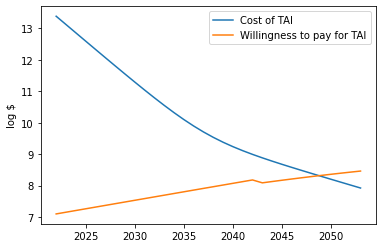

2053: ...Tool TAI made
2100: WAR!!! (US vs. Russia)
2109: North Korea uses a nuke first strike!
2114: North Korea uses a nuke first strike!
2138: War ends :)
...Boring future
-
-
-
-
############
## RUN 32 ##
############
Anchor debug:
-- Assume human brain in inference takes 11.3 log FLOP (i.e., 10^11.3 FLOP)
-- Add 1.8 log FLOP for efficiency
-- Assume a transformative model takes -1.6 log FLOP compared to human
-- Assume a horizon length of 1.9
-- Assume a scaling exponent of 0.666
-- Assume FLOPs per param per sec of 1.2
-- 25.9 = 11.3 + 1.8 + -1.6 + 1.9 + 12 - 0.666 * 11.2 + 0.666 * (11.3 + 1.8 - 1.2)
-- 25.9 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 25.9 log FLOPs (~81 septillion) for transformative capabilities.
Every 2.7 years algorithms get 2x better, with 1.8 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 s

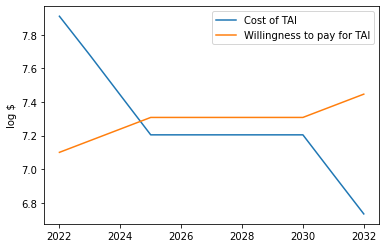

2032: ...XRISK from fully unaligned TAI (singleton) :(
...Singleton is catastrophic
-
-
-
-
############
## RUN 33 ##
############
Anchor debug:
-- Assume human brain in inference takes 16.1 log FLOP (i.e., 10^16.1 FLOP)
-- Add 4.4 log FLOP for efficiency
-- Assume a transformative model takes 0.7 log FLOP compared to human
-- Assume a horizon length of 1.1
-- Assume a scaling exponent of 1.271
-- Assume FLOPs per param per sec of 1.2
-- 44.7 = 16.1 + 4.4 + 0.7 + 1.1 + 12 - 1.271 * 11.2 + 1.271 * (16.1 + 4.4 - 1.2)
-- 44.7 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 44.7 log FLOPs (~548 billion decillion) for transformative capabilities.
Every 1.2 years algorithms get 2x better, with 5.2 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.1 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.5 log 2022$USD (~31 million) and thi

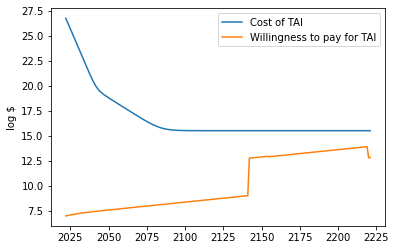

-
-
-
-
############
## RUN 34 ##
############
Anchor debug:
-- Assume human brain in inference takes 9.3 log FLOP (i.e., 10^9.3 FLOP)
-- Add 1.0 log FLOP for efficiency
-- Assume a transformative model takes 1.0 log FLOP compared to human
-- Assume a horizon length of 3.1
-- Assume a scaling exponent of 0.948
-- Assume FLOPs per param per sec of 1.7
-- 23.9 = 9.3 + 1.0 + 1.0 + 3.1 + 12 - 0.948 * 11.2 + 0.948 * (9.3 + 1.0 - 1.7)
-- 27.7 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 27.7 log FLOPs (~5 octillion) for transformative capabilities.
Every 2.9 years algorithms get 2x better, with 1.0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 4.2 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 4.2x per year to a max of 0.00068% of GDP. GDP grows at a rate of 1.022x per year.


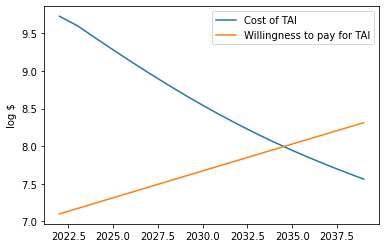

2039: ...XRISK from fully unaligned TAI (singleton) :(
...Singleton is catastrophic
-
-
-
-
############
## RUN 35 ##
############
Anchor debug:
-- Assume human brain in inference takes 12.5 log FLOP (i.e., 10^12.5 FLOP)
-- Add 1.6 log FLOP for efficiency
-- Assume a transformative model takes 0.3 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.471
-- Assume FLOPs per param per sec of 1.4
-- 27.1 = 12.5 + 1.6 + 0.3 + 0 + 12 - 0.471 * 11.2 + 0.471 * (12.5 + 1.6 - 1.4)
-- 27.1 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 27.1 log FLOPs (~1 octillion) for transformative capabilities.
Every 2.7 years algorithms get 2x better, with 2.1 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.6 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by

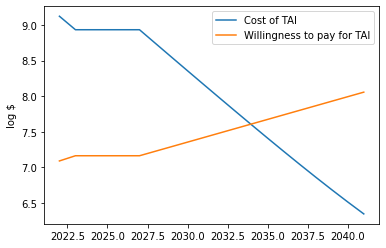

2041: ...XRISK from fully unaligned TAI (singleton) :(
...Singleton is catastrophic
-
-
-
-
############
## RUN 36 ##
############
Anchor debug:
-- Assume human brain in inference takes 12.5 log FLOP (i.e., 10^12.5 FLOP)
-- Add 4.2 log FLOP for efficiency
-- Assume a transformative model takes -0.2 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.192
-- Assume FLOPs per param per sec of 1.3
-- 33.4 = 12.5 + 4.2 + -0.2 + 0 + 12 - 1.192 * 11.2 + 1.192 * (12.5 + 4.2 - 1.3)
-- 33.4 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 33.4 log FLOPs (~3 decillion) for transformative capabilities.
Every 1.2 years algorithms get 2x better, with 4.9 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.2 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases 

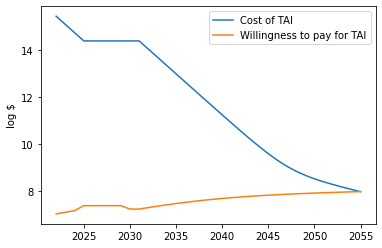

2055: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 37 ##
############
Anchor debug:
-- Assume human brain in inference takes 19.6 log FLOP (i.e., 10^19.6 FLOP)
-- Add 0.9 log FLOP for efficiency
-- Assume a transformative model takes -1.5 log FLOP compared to human
-- Assume a horizon length of 0.4
-- Assume a scaling exponent of 1.449
-- Assume FLOPs per param per sec of 1.9
-- 42.2 = 19.6 + 0.9 + -1.5 + 0.4 + 12 - 1.449 * 11.2 + 1.449 * (19.6 + 0.9 - 1.9)
-- 42.2 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 42.2 log FLOPs (~2 billion decillion) for transformative capabilities.
Every 1.8 years algorithms get 2x better, with 2.2 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this 

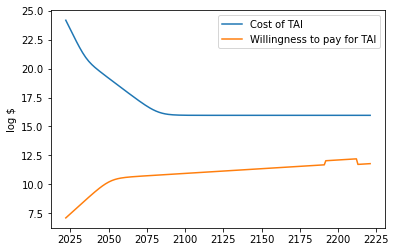

-
-
-
-
############
## RUN 38 ##
############
Anchor debug:
-- Assume human brain in inference takes 15.0 log FLOP (i.e., 10^15.0 FLOP)
-- Add 1.8 log FLOP for efficiency
-- Assume a transformative model takes -0.7 log FLOP compared to human
-- Assume a horizon length of 2.8
-- Assume a scaling exponent of 0.438
-- Assume FLOPs per param per sec of 1.7
-- 32.7 = 15.0 + 1.8 + -0.7 + 2.8 + 12 - 0.438 * 11.2 + 0.438 * (15.0 + 1.8 - 1.7)
-- 32.7 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 32.7 log FLOPs (~457 nonillion) for transformative capabilities.
Every 2.2 years algorithms get 2x better, with 1.8 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 4.0 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 4.3x per year to a max of 0.00062% of GDP. GDP grows at a rate of 1.028x pe

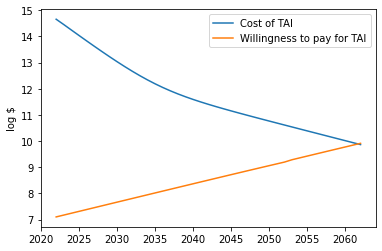

2062: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 39 ##
############
Anchor debug:
-- Assume human brain in inference takes 14.9 log FLOP (i.e., 10^14.9 FLOP)
-- Add 1.9 log FLOP for efficiency
-- Assume a transformative model takes -1.8 log FLOP compared to human
-- Assume a horizon length of 2.9
-- Assume a scaling exponent of 0.818
-- Assume FLOPs per param per sec of 1.8
-- 33.0 = 14.9 + 1.9 + -1.8 + 2.9 + 12 - 0.818 * 11.2 + 0.818 * (14.9 + 1.9 - 1.8)
-- 33.0 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 33.0 log FLOPs (~1 decillion) for transformative capabilities.
Every 1.9 years algorithms get 2x better, with 1.9 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 5.4 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increase

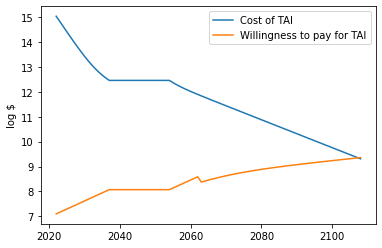

2108: ...Tool TAI made
...Boring future
-
-
-
-
############
## RUN 40 ##
############
Anchor debug:
-- Assume human brain in inference takes 13.9 log FLOP (i.e., 10^13.9 FLOP)
-- Add 1.4 log FLOP for efficiency
-- Assume a transformative model takes 0.6 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.913
-- Assume FLOPs per param per sec of 1.1
-- 30.7 = 13.9 + 1.4 + 0.6 + 0 + 12 - 0.913 * 11.2 + 0.913 * (13.9 + 1.4 - 1.1)
-- 30.7 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 30.7 log FLOPs (~5 nonillion) for transformative capabilities.
Every 1.7 years algorithms get 2x better, with 3.4 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.3 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.5 log 2022$USD (~32 million) and this increases by 3.6x per year to a max of 0.00086% of GDP. 

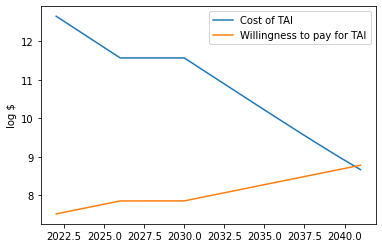

2041: ...XRISK from fully unaligned TAI (singleton) :(
...Singleton is catastrophic
-
-
-
-
############
## RUN 41 ##
############
Anchor debug:
-- Assume human brain in inference takes 15.6 log FLOP (i.e., 10^15.6 FLOP)
-- Add 3.2 log FLOP for efficiency
-- Assume a transformative model takes -0.1 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.959
-- Assume FLOPs per param per sec of 1.7
-- 36.3 = 15.6 + 3.2 + -0.1 + 0 + 12 - 0.959 * 11.2 + 0.959 * (15.6 + 3.2 - 1.7)
-- 36.3 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 36.3 log FLOPs (~2 thousand decillion) for transformative capabilities.
Every 1.1 years algorithms get 2x better, with 3.2 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this i

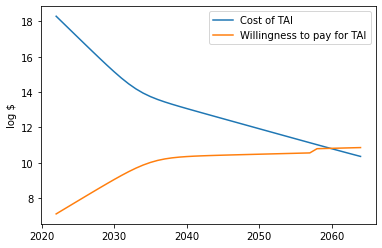

2064: ...XRISK from fully unaligned TAI (singleton) :(
...Singleton is catastrophic
-
-
-
-
############
## RUN 42 ##
############
Anchor debug:
-- Assume human brain in inference takes 11.0 log FLOP (i.e., 10^11.0 FLOP)
-- Add 0.9 log FLOP for efficiency
-- Assume a transformative model takes 0.7 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.206
-- Assume FLOPs per param per sec of 1.1
-- 24.0 = 11.0 + 0.9 + 0.7 + 0 + 12 - 1.206 * 11.2 + 1.206 * (11.0 + 0.9 - 1.1)
-- 29.3 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 29.3 log FLOPs (~211 octillion) for transformative capabilities.
Every 2.3 years algorithms get 2x better, with 3.0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.1 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.4 log 2022$USD (~24 million) and this increases 

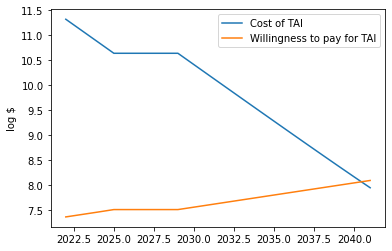

2041: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 43 ##
############
Anchor debug:
-- Assume human brain in inference takes 12.2 log FLOP (i.e., 10^12.2 FLOP)
-- Add 1.7 log FLOP for efficiency
-- Assume a transformative model takes -0.0 log FLOP compared to human
-- Assume a horizon length of 4.2
-- Assume a scaling exponent of 0.831
-- Assume FLOPs per param per sec of 1.4
-- 31.0 = 12.2 + 1.7 + -0.0 + 4.2 + 12 - 0.831 * 11.2 + 0.831 * (12.2 + 1.7 - 1.4)
-- 31.0 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 31.0 log FLOPs (~11 nonillion) for transformative capabilities.
Every 1.4 years algorithms get 2x better, with 1.7 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increas

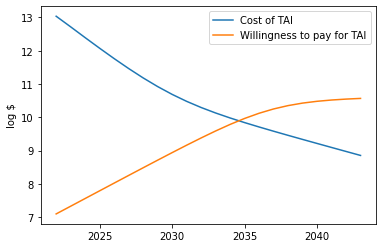

2043: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 44 ##
############
Anchor debug:
-- Assume human brain in inference takes 13.4 log FLOP (i.e., 10^13.4 FLOP)
-- Add 1.8 log FLOP for efficiency
-- Assume a transformative model takes -0.3 log FLOP compared to human
-- Assume a horizon length of 4.8
-- Assume a scaling exponent of 1.097
-- Assume FLOPs per param per sec of 2.1
-- 33.6 = 13.4 + 1.8 + -0.3 + 4.8 + 12 - 1.097 * 11.2 + 1.097 * (13.4 + 1.8 - 2.1)
-- 33.6 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 33.6 log FLOPs (~4 decillion) for transformative capabilities.
Every 1.1 years algorithms get 2x better, with 3.4 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 4.0 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increase

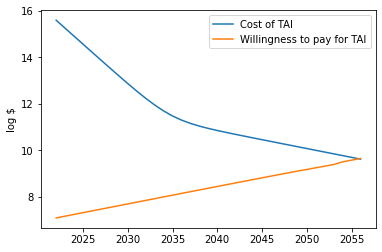

2056: ...XRISK from fully unaligned TAI (extinction) :(
-
-
-
-
############
## RUN 45 ##
############
Anchor debug:
-- Assume human brain in inference takes 11.4 log FLOP (i.e., 10^11.4 FLOP)
-- Add 1.9 log FLOP for efficiency
-- Assume a transformative model takes -2.0 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.506
-- Assume FLOPs per param per sec of 1.5
-- 24.0 = 11.4 + 1.9 + -2.0 + 0 + 12 - 1.506 * 11.2 + 1.506 * (11.4 + 1.9 - 1.5)
-- 24.0 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 24.0 log FLOPs (~985 sextillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 3.3 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.6 log 2022$USD (~40 million) and this increases by 4.9x per year to a max

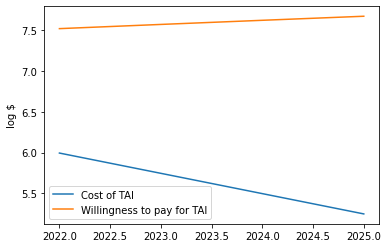

2025: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 46 ##
############
Anchor debug:
-- Assume human brain in inference takes 15.3 log FLOP (i.e., 10^15.3 FLOP)
-- Add 1.7 log FLOP for efficiency
-- Assume a transformative model takes -0.8 log FLOP compared to human
-- Assume a horizon length of 8.5
-- Assume a scaling exponent of 0.947
-- Assume FLOPs per param per sec of 1.6
-- 40.7 = 15.3 + 1.7 + -0.8 + 8.5 + 12 - 0.947 * 11.2 + 0.947 * (15.3 + 1.7 - 1.6)
-- 40.7 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 40.7 log FLOPs (~46 million decillion) for transformative capabilities.
Every 1.4 years algorithms get 2x better, with 3.8 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this

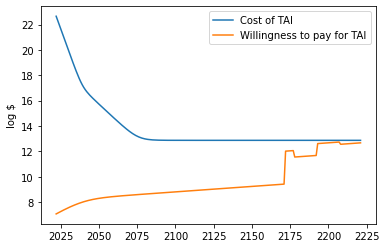

-
-
-
-
############
## RUN 47 ##
############
Anchor debug:
-- Assume human brain in inference takes 13.1 log FLOP (i.e., 10^13.1 FLOP)
-- Add 3.0 log FLOP for efficiency
-- Assume a transformative model takes -1.2 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.05
-- Assume FLOPs per param per sec of 1.2
-- 30.7 = 13.1 + 3.0 + -1.2 + 0 + 12 - 1.05 * 11.2 + 1.05 * (13.1 + 3.0 - 1.2)
-- 30.7 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 30.7 log FLOPs (~5 nonillion) for transformative capabilities.
Every 1.7 years algorithms get 2x better, with 3.8 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.0 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 4.9x per year to a max of 0.00075% of GDP. GDP grows at a rate of 1.029x per year.
I

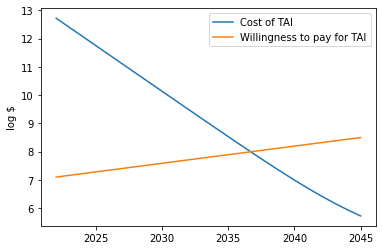

2045: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 48 ##
############
Anchor debug:
-- Assume human brain in inference takes 14.2 log FLOP (i.e., 10^14.2 FLOP)
-- Add 1.7 log FLOP for efficiency
-- Assume a transformative model takes -0.7 log FLOP compared to human
-- Assume a horizon length of 8.4
-- Assume a scaling exponent of 1.171
-- Assume FLOPs per param per sec of 1.3
-- 39.7 = 14.2 + 1.7 + -0.7 + 8.4 + 12 - 1.171 * 11.2 + 1.171 * (14.2 + 1.7 - 1.3)
-- 39.7 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 39.7 log FLOPs (~5 million decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 2.6 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this 

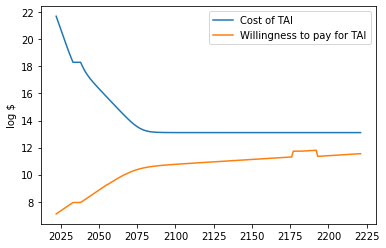

-
-
-
-
############
## RUN 49 ##
############
Anchor debug:
-- Assume human brain in inference takes 15.1 log FLOP (i.e., 10^15.1 FLOP)
-- Add 1.0 log FLOP for efficiency
-- Assume a transformative model takes 1.1 log FLOP compared to human
-- Assume a horizon length of 2.5
-- Assume a scaling exponent of 0.623
-- Assume FLOPs per param per sec of 1.7
-- 33.7 = 15.1 + 1.0 + 1.1 + 2.5 + 12 - 0.623 * 11.2 + 0.623 * (15.1 + 1.0 - 1.7)
-- 33.7 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 33.7 log FLOPs (~5 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 1.0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.6 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.9 log 2022$USD (~73 million) and this increases by 1.8x per year to a max of 6e-05% of GDP. GDP grows at a rate of 1.014x per year

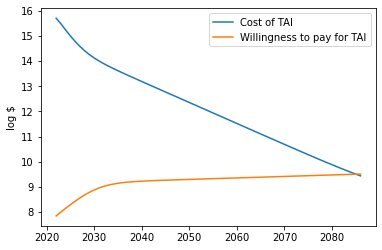

2086: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 50 ##
############
Anchor debug:
-- Assume human brain in inference takes 14.9 log FLOP (i.e., 10^14.9 FLOP)
-- Add 1.2 log FLOP for efficiency
-- Assume a transformative model takes 1.0 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.639
-- Assume FLOPs per param per sec of 1.4
-- 31.2 = 14.9 + 1.2 + 1.0 + 0 + 12 - 0.639 * 11.2 + 0.639 * (14.9 + 1.2 - 1.4)
-- 31.2 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 31.2 log FLOPs (~17 nonillion) for transformative capabilities.
Every 1.7 years algorithms get 2x better, with 1.2 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 

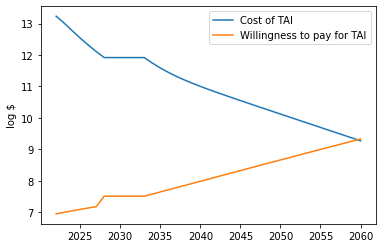

2060: ...XRISK from fully unaligned TAI (singleton) :(
...Singleton is catastrophic
-
-


In [18]:
for i in range(50):
    print('-')
    print('-')
    print('############')
    print('## RUN {} ##'.format(i + 1))
    print('############')
    define_event(verbosity=2)

In [19]:
collectors = bayes.bayesnet(define_event,
                            find=lambda e: e['collectors'],
                            load_cache_file='future_assessment_model_cache',
                            dump_cache_file='future_assessment_model_cache',
                            raw=True,
                            verbose=True,
                            reload_cache=False,
                            n=RUNS)

Reloading cache...
Generating Bayes net...


100%|█████████████████████████████████████████████████████████| 100000/100000 [50:06<00:00, 33.26it/s]


...Generated
Caching in-memory...
...Cached
Writing cache to file `future_assessment_model_cache.sqcache.pkl`...
...Cached


In [20]:
def print_states(states):
    c = Counter(states)
    c = dict([(k, round(v / RUNS * 100, 3)) for k, v in c.items()])
    for k in c.keys():
        if k not in STATES:
            raise ValueError('State {} not in `STATES`'.format(k))
    for state in STATES:
        if not c.get(state):
            c[state] = 0.0
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    return c


print('0. World State At Year')
for y_c in [2030, 2050, 2070, 2100, 2200]:
    print('## {} ##'.format(y_c)) 
    pprint(print_states([c[y_c]['category'] for c in collectors]))
    print('-')
    print('-')

0. World State At Year
## 2030 ##
[('boring', 97.233),
 ('xrisk_full_unaligned_tai_singleton', 1.021),
 ('xrisk_full_unaligned_tai_extinction', 0.706),
 ('aligned_tai', 0.585),
 ('xrisk_tai_misuse', 0.184),
 ('xrisk_subtly_unaligned_tai', 0.139),
 ('xrisk_nukes_war', 0.093),
 ('xrisk_nukes_accident', 0.02),
 ('xrisk_bio_accident', 0.009),
 ('xrisk_unknown_unknown', 0.007),
 ('xrisk_bio_war', 0.002),
 ('xrisk_nanotech', 0.001),
 ('xrisk_bio_nonstate', 0.0),
 ('xrisk_supervolcano', 0.0)]
-
-
## 2050 ##
[('boring', 75.466),
 ('aligned_tai', 11.273),
 ('xrisk_full_unaligned_tai_singleton', 5.608),
 ('xrisk_full_unaligned_tai_extinction', 3.778),
 ('xrisk_subtly_unaligned_tai', 2.071),
 ('xrisk_tai_misuse', 1.424),
 ('xrisk_nukes_war', 0.232),
 ('xrisk_nukes_accident', 0.09),
 ('xrisk_unknown_unknown', 0.028),
 ('xrisk_bio_accident', 0.022),
 ('xrisk_bio_war', 0.004),
 ('xrisk_nanotech', 0.002),
 ('xrisk_bio_nonstate', 0.002),
 ('xrisk_supervolcano', 0.0)]
-
-
## 2070 ##
[('boring', 59.294)

In [21]:
print('0B. Catastrophe States At Year')

def print_catastrophe(catastrophes):
    c = Counter([' '.join(sorted(c)) for c in catastrophes])
    c = dict([(k, round(v / RUNS * 100, 2)) for k, v in c.items()])
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    c = [c_ for c_ in c if c_[1] >= 0.1]
    return c

for y_c in [2023, 2030, 2050, 2070, 2100, 2200]:
    print('## {} ##'.format(y_c))  
    pprint(print_catastrophe([c[y_c]['catastrophe'] for c in collectors]))
    print('-')
    print('-')

0B. Catastrophe States At Year
## 2023 ##
[('', 99.5),
 ('nukes_war', 0.12),
 ('natural_pathogen', 0.12),
 ('engineered_pathogen', 0.11)]
-
-
## 2030 ##
[('', 95.22),
 ('nukes_war', 1.38),
 ('xrisk_full_unaligned_tai_singleton', 0.83),
 ('xrisk_full_unaligned_tai_extinction', 0.7),
 ('engineered_pathogen', 0.58),
 ('natural_pathogen', 0.46),
 ('nukes_accident', 0.45),
 ('xrisk_tai_misuse', 0.14),
 ('averting_misaligned_tai', 0.12)]
-
-
## 2050 ##
[('', 82.12),
 ('xrisk_full_unaligned_tai_singleton', 4.42),
 ('xrisk_full_unaligned_tai_extinction', 3.69),
 ('nukes_war', 3.16),
 ('engineered_pathogen', 1.62),
 ('nukes_accident', 1.34),
 ('natural_pathogen', 1.14),
 ('xrisk_tai_misuse', 1.07),
 ('averting_misaligned_tai', 0.62),
 ('nukes_accident nukes_war', 0.1),
 ('nukes_war nukes_war', 0.1)]
-
-
## 2070 ##
[('', 76.82),
 ('xrisk_full_unaligned_tai_singleton', 5.75),
 ('xrisk_full_unaligned_tai_extinction', 4.85),
 ('nukes_war', 3.54),
 ('engineered_pathogen', 2.25),
 ('nukes_accident', 

In [22]:
print('0C. *First* Catastrophe State At Year')

def print_catastrophe_first(catastrophes):
    c = Counter([c[0] if len(c) > 0 else '' for c in catastrophes])
    c = dict([(k, round(v / RUNS * 100, 2)) for k, v in c.items()])
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    c = [c_ for c_ in c if c_[1] >= 0.1]
    return c

for y_c in [2023, 2030, 2050, 2070, 2100, 2200]:
    print('## {} ##'.format(y_c))  
    pprint(print_catastrophe_first([c[y_c]['catastrophe'] for c in collectors]))
    print('-')
    print('-')

0C. *First* Catastrophe State At Year
## 2023 ##
[('', 99.5),
 ('nukes_war', 0.12),
 ('natural_pathogen', 0.12),
 ('engineered_pathogen', 0.11)]
-
-
## 2030 ##
[('', 95.22),
 ('nukes_war', 1.44),
 ('xrisk_full_unaligned_tai_singleton', 0.83),
 ('xrisk_full_unaligned_tai_extinction', 0.7),
 ('engineered_pathogen', 0.6),
 ('natural_pathogen', 0.48),
 ('nukes_accident', 0.47),
 ('xrisk_tai_misuse', 0.14),
 ('averting_misaligned_tai', 0.12)]
-
-
## 2050 ##
[('', 82.12),
 ('xrisk_full_unaligned_tai_singleton', 4.42),
 ('xrisk_full_unaligned_tai_extinction', 3.69),
 ('nukes_war', 3.51),
 ('engineered_pathogen', 1.76),
 ('nukes_accident', 1.48),
 ('natural_pathogen', 1.22),
 ('xrisk_tai_misuse', 1.07),
 ('averting_misaligned_tai', 0.64)]
-
-
## 2070 ##
[('', 76.82),
 ('xrisk_full_unaligned_tai_singleton', 5.75),
 ('xrisk_full_unaligned_tai_extinction', 4.85),
 ('nukes_war', 4.18),
 ('engineered_pathogen', 2.52),
 ('nukes_accident', 1.86),
 ('natural_pathogen', 1.67),
 ('xrisk_tai_misuse', 1.3

In [23]:
print('0D. Double Catastrophe X-Risks')

def print_double_catastrophes(catastrophes):
    c = Counter(['' if c is None else c for c in catastrophes])
    c = dict([(k, round(v / RUNS * 100, 3)) for k, v in c.items()])
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    # c = [c_ for c_ in c if c_[1] >= 0.1]
    return c

for y_c in [2030, 2050, 2070, 2100, 2200]:
    print('## {} ##'.format(y_c))  
    pprint(print_double_catastrophes([c[y_c]['double_catastrophe_xrisk'] for c in collectors]))
    print('-')
    print('-')

0D. Double Catastrophe X-Risks
## 2030 ##
[('', 99.993),
 ('nukes_war->nukes_accident', 0.002),
 ('engineered_pathogen->natural_pathogen', 0.001),
 ('nukes_war->nukes_war', 0.001),
 ('nukes_accident->nukes_war', 0.001),
 ('nukes_war->engineered_pathogen', 0.001),
 ('natural_pathogen->nukes_war', 0.001)]
-
-
## 2050 ##
[('', 99.965),
 ('nukes_war->nukes_war', 0.01),
 ('nukes_accident->nukes_war', 0.008),
 ('nukes_war->engineered_pathogen', 0.004),
 ('nukes_war->nukes_accident', 0.003),
 ('engineered_pathogen->natural_pathogen', 0.002),
 ('engineered_pathogen->nukes_war', 0.002),
 ('nukes_war->natural_pathogen', 0.002),
 ('natural_pathogen->nukes_war', 0.002),
 ('natural_pathogen->natural_pathogen', 0.001),
 ('engineered_pathogen->nukes_accident', 0.001)]
-
-
## 2070 ##
[('', 99.955),
 ('nukes_war->nukes_war', 0.012),
 ('nukes_accident->nukes_war', 0.008),
 ('nukes_war->engineered_pathogen', 0.005),
 ('engineered_pathogen->nukes_war', 0.004),
 ('nukes_war->nukes_accident', 0.003),
 ('eng

In [24]:
print('0E. # of Catastrophes At Year')

for y_c in [2030, 2050, 2070, 2100, 2200]:
    print('## # of catastrophes as of {} ##'.format(y_c))  
    pprint(sq.get_percentiles([len(c[y_c]['catastrophe']) for c in collectors]))
    print('-')
    print('-')

0E. # of Catastrophes At Year
## # of catastrophes as of 2030 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 0.0,
 90: 0.0,
 95: 0.0,
 99: 1.0}
-
-
## # of catastrophes as of 2050 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 0.0,
 90: 1.0,
 95: 1.0,
 99: 1.0}
-
-
## # of catastrophes as of 2070 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 1.0,
 90: 1.0,
 95: 1.0,
 99: 2.0}
-
-
## # of catastrophes as of 2100 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 1.0,
 90: 1.0,
 95: 1.0,
 99: 2.0}
-
-
## # of catastrophes as of 2200 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 1.0,
 80: 1.0,
 90: 1.0,
 95: 1.0,
 99: 2.0}
-
-


In [25]:
print('0F. War States At Year')

def print_wars(wars):
    bs = [[w['belligerents'] if w != [] else [] for w in ws] for ws in wars]
    bs = Counter([' '.join(sorted(b)) for b in bs])    
    bs = dict([(k, round(v / RUNS * 100, 3)) for k, v in bs.items()])
    bs = sorted(bs.items(), key=lambda x: x[1], reverse=True)
    return bs

for y_c in [2030, 2050, 2070, 2100, 2200]:
    print('## {} ##'.format(y_c))  
    pprint(print_wars([c[y_c]['wars'] for c in collectors]))
    print('-')
    print('-')

0F. War States At Year
## 2030 ##
[('', 56.643),
 ('US/China', 33.454),
 ('US/Russia', 8.243),
 ('Other', 0.673),
 ('US/China US/China', 0.592),
 ('US/China US/Russia', 0.359),
 ('Other US/China', 0.031),
 ('US/Russia US/Russia', 0.003),
 ('US/China US/China US/China', 0.001),
 ('Other US/Russia', 0.001)]
-
-
## 2050 ##
[('US/China', 42.477),
 ('', 40.084),
 ('US/Russia', 10.361),
 ('Other', 2.692),
 ('US/China US/China', 2.57),
 ('US/China US/Russia', 1.139),
 ('Other US/China', 0.437),
 ('Other US/Russia', 0.084),
 ('US/Russia US/Russia', 0.059),
 ('US/China US/China US/China', 0.042),
 ('US/China US/China US/Russia', 0.017),
 ('Other US/China US/China', 0.013),
 ('Other US/China US/Russia', 0.01),
 ('Other Other', 0.005),
 ('US/China US/China US/China US/China', 0.005),
 ('US/China US/Russia US/Russia', 0.002),
 ('US/China US/China US/China US/China US/China', 0.001),
 ('Other Other US/China US/China', 0.001),
 ('Other Other US/China', 0.001)]
-
-
## 2070 ##
[('US/China', 40.771),
 

In [26]:
print('0G. War Length States At Year')

def print_wars(y, wars):
    bs = [[(w['end_year'] - w['start_year'] if w['end_year'] < y else y - w['start_year']) if w != [] else 0 for w in ws] for ws in wars]
    bs = [round(sum(b) / (y - CURRENT_YEAR) * 100, 1) for b in bs]
    return bs

for y_c in [2030, 2050, 2070, 2100, 2200]:
    print('## Percent of time in war as of {} ##'.format(y_c))  
    pprint(sq.get_percentiles(print_wars(y_c, [c[y_c]['wars'] for c in collectors])))
    print('-')
    print('-')

0G. War Length States At Year
## Percent of time in war as of 2030 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 25.0,
 80: 50.0,
 90: 75.0,
 95: 75.0,
 99: 87.5}
-
-
## Percent of time in war as of 2050 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 14.3,
 60: 25.0,
 70: 35.7,
 80: 53.6,
 90: 71.4,
 95: 85.7,
 99: 92.9}
-
-
## Percent of time in war as of 2070 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 6.2,
 50: 10.4,
 60: 16.7,
 70: 25.0,
 80: 35.4,
 90: 56.2,
 95: 77.1,
 99: 95.8}
-
-
## Percent of time in war as of 2100 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 5.1,
 50: 9.0,
 60: 12.8,
 70: 17.9,
 80: 25.6,
 90: 39.7,
 95: 55.1,
 99: 89.7}
-
-
## Percent of time in war as of 2200 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 1.7,
 40: 3.4,
 50: 5.6,
 60: 7.9,
 70: 11.2,
 80: 15.2,
 90: 23.6,
 95: 32.0,
 99: 56.20499999999738}
-
-


In [27]:
print('0H. # of Wars At Year')

for y_c in [2030, 2050, 2070, 2100, 2200]:
    print('## # of wars as of {} ##'.format(y_c))  
    pprint(sq.get_percentiles([len(c[y_c]['wars']) for c in collectors]))
    print('-')
    print('-')

0H. # of Wars At Year
## # of wars as of 2030 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 1.0,
 70: 1.0,
 80: 1.0,
 90: 1.0,
 95: 1.0,
 99: 1.0}
-
-
## # of wars as of 2050 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 1.0,
 60: 1.0,
 70: 1.0,
 80: 1.0,
 90: 1.0,
 95: 1.0,
 99: 2.0}
-
-
## # of wars as of 2070 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 1.0,
 50: 1.0,
 60: 1.0,
 70: 1.0,
 80: 1.0,
 90: 1.0,
 95: 2.0,
 99: 2.0}
-
-
## # of wars as of 2100 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 1.0,
 50: 1.0,
 60: 1.0,
 70: 1.0,
 80: 1.0,
 90: 2.0,
 95: 2.0,
 99: 2.0}
-
-
## # of wars as of 2200 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 1.0,
 40: 1.0,
 50: 1.0,
 60: 1.0,
 70: 1.0,
 80: 2.0,
 90: 2.0,
 95: 3.0,
 99: 3.0}
-
-


In [28]:
print('1. Genetically Engineered Pathogen Risk* (1%+ death)')
for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['engineered_pathogen'],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))
    

1. Genetically Engineered Pathogen Risk* (1%+ death)
2030 - 1.94%
2050 - 5.7%
2100 - 10.8%


In [29]:
print('2. Non-Genetically Engineered Pathogen Risk* (1%+ death)')
for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['natural_pathogen'],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))    

2. Non-Genetically Engineered Pathogen Risk* (1%+ death)
2030 - 1.46%
2050 - 3.84%
2100 - 6.96%


In [30]:
print('2B. Pathogen Catastrophic Risk (10%+ death)')
for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'pathogen' in ' '.join(e['collectors'][y_c]['catastrophe']),
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))


2B. Pathogen Catastrophic Risk (10%+ death)
2030 - 1.09%
2050 - 3.1%
2100 - 5.75%


In [31]:
print('2C. Pathogen Extinction Risk')
for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'xrisk_bio' in e['collectors'][y_c]['category'],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 3)))
    

2C. Pathogen Extinction Risk
2030 - 0.011%
2050 - 0.028%
2100 - 0.045%


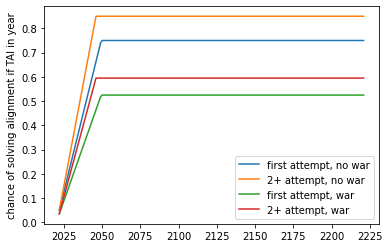

In [32]:
alignment_p = np.array([p_alignment_solved(war=False, year=y - CURRENT_YEAR, first_attempt=True) for y in years])
alignment_p2 = np.array([p_alignment_solved(war=False, year=y - CURRENT_YEAR, first_attempt=False) for y in years])
alignment_pwar = np.array([p_alignment_solved(war=True, year=y - CURRENT_YEAR, first_attempt=True) for y in years])
alignment_p2war = np.array([p_alignment_solved(war=True, year=y - CURRENT_YEAR, first_attempt=False) for y in years])
plt.plot(years, alignment_p, label='first attempt, no war')
plt.plot(years, alignment_p2, label='2+ attempt, no war')
plt.plot(years, alignment_pwar, label='first attempt, war')
plt.plot(years, alignment_p2war, label='2+ attempt, war')
plt.legend()
plt.ylabel('chance of solving alignment if TAI in year')
plt.show()


In [33]:
for y in years:
    str_ = 'Year: {} - chance of solving TAI alignment with no war {}% (2nd attempt {}%)'
    print(str_.format(y,
                      round(alignment_p[y - CURRENT_YEAR] * 100, 0),
                      round(alignment_p2[y - CURRENT_YEAR] * 100, 0)))

Year: 2022 - chance of solving TAI alignment with no war 5.0% (2nd attempt 5.0%)
Year: 2023 - chance of solving TAI alignment with no war 8.0% (2nd attempt 8.0%)
Year: 2024 - chance of solving TAI alignment with no war 10.0% (2nd attempt 12.0%)
Year: 2025 - chance of solving TAI alignment with no war 13.0% (2nd attempt 15.0%)
Year: 2026 - chance of solving TAI alignment with no war 15.0% (2nd attempt 18.0%)
Year: 2027 - chance of solving TAI alignment with no war 18.0% (2nd attempt 22.0%)
Year: 2028 - chance of solving TAI alignment with no war 20.0% (2nd attempt 25.0%)
Year: 2029 - chance of solving TAI alignment with no war 23.0% (2nd attempt 28.0%)
Year: 2030 - chance of solving TAI alignment with no war 25.0% (2nd attempt 32.0%)
Year: 2031 - chance of solving TAI alignment with no war 28.0% (2nd attempt 35.0%)
Year: 2032 - chance of solving TAI alignment with no war 31.0% (2nd attempt 38.0%)
Year: 2033 - chance of solving TAI alignment with no war 33.0% (2nd attempt 42.0%)
Year: 20

In [34]:
for y in years:
    str_ = 'Year: {} - chance of solving TAI alignment with war {}% (2nd attempt {}%)'
    print(str_.format(y,
                      round(alignment_pwar[y - CURRENT_YEAR] * 100, 0),
                      round(alignment_p2war[y - CURRENT_YEAR] * 100, 0)))


Year: 2022 - chance of solving TAI alignment with war 3.0% (2nd attempt 3.0%)
Year: 2023 - chance of solving TAI alignment with war 5.0% (2nd attempt 6.0%)
Year: 2024 - chance of solving TAI alignment with war 7.0% (2nd attempt 8.0%)
Year: 2025 - chance of solving TAI alignment with war 9.0% (2nd attempt 11.0%)
Year: 2026 - chance of solving TAI alignment with war 11.0% (2nd attempt 13.0%)
Year: 2027 - chance of solving TAI alignment with war 12.0% (2nd attempt 15.0%)
Year: 2028 - chance of solving TAI alignment with war 14.0% (2nd attempt 18.0%)
Year: 2029 - chance of solving TAI alignment with war 16.0% (2nd attempt 20.0%)
Year: 2030 - chance of solving TAI alignment with war 18.0% (2nd attempt 22.0%)
Year: 2031 - chance of solving TAI alignment with war 20.0% (2nd attempt 24.0%)
Year: 2032 - chance of solving TAI alignment with war 21.0% (2nd attempt 27.0%)
Year: 2033 - chance of solving TAI alignment with war 23.0% (2nd attempt 29.0%)
Year: 2034 - chance of solving TAI alignment wi

In [35]:
print('3. AI Catastrophic Risk* (10%+ death)')
for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'tai' in ' '.join(e['collectors'][y_c]['catastrophe']),
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))

3. AI Catastrophic Risk* (10%+ death)
2030 - 1.81%
2050 - 10.11%
2100 - 16.05%


In [36]:
print('4. AI Extinction Risk*')
for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['category'] == 'xrisk_full_unaligned_tai_extinction',
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))


4. AI Extinction Risk*
2030 - 0.71%
2050 - 3.78%
2100 - 6.02%


In [37]:
print('4B. AI X-Risk')

def find(y_c, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: e['collectors'][y_c]['category'] == category,
                          n=RUNS)

for y_c in [2024, 2030, 2050, 2070, 2100, 2200]:
    extinction = find(y_c, 'xrisk_full_unaligned_tai_extinction')
    singleton = find(y_c, 'xrisk_full_unaligned_tai_singleton')
    subtle_misalignment = find(y_c, 'xrisk_subtly_unaligned_tai')
    misuse = find(y_c, 'xrisk_tai_misuse')
    out = '{} - {}% (Extinction: {}%, Bad TAI singleton: {}%, Subtly misaligned singleton: {}%, Misuse singleton: {}%)'
    print(out.format(y_c,
                     round((extinction + singleton + subtle_misalignment + misuse) * 100, 1),
                     round(extinction * 100, 1),
                     round(singleton * 100, 1),
                     round(subtle_misalignment * 100, 1),
                     round(misuse * 100, 1)))


4B. AI X-Risk
2024 - 0.2% (Extinction: 0.1%, Bad TAI singleton: 0.1%, Subtly misaligned singleton: 0.0%, Misuse singleton: 0.0%)
2030 - 2.1% (Extinction: 0.7%, Bad TAI singleton: 1.0%, Subtly misaligned singleton: 0.1%, Misuse singleton: 0.2%)
2050 - 12.9% (Extinction: 3.8%, Bad TAI singleton: 5.6%, Subtly misaligned singleton: 2.1%, Misuse singleton: 1.4%)
2070 - 18.3% (Extinction: 5.1%, Bad TAI singleton: 7.5%, Subtly misaligned singleton: 3.9%, Misuse singleton: 1.9%)
2100 - 22.3% (Extinction: 6.0%, Bad TAI singleton: 8.9%, Subtly misaligned singleton: 5.2%, Misuse singleton: 2.2%)
2200 - 25.2% (Extinction: 6.7%, Bad TAI singleton: 10.0%, Subtly misaligned singleton: 6.0%, Misuse singleton: 2.5%)


In [38]:
# “P(misalignment x-risk|AGI)”: Conditional on AGI being developed by 2070, humanity will go extinct or
# drastically curtail its future potential due to loss of control of AGI

print('4C. AI X-Risk conditional on AGI by 2070')

def find(y_c, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: e['collectors'][y_c]['category'] == category,
                          conditional_on=lambda e: e['final_state']['tai_year'] <= 2070 if e['final_state']['tai_year'] is not None else False,
                          n=RUNS)

for y_c in [2070, 2100]:
    extinction = find(y_c, 'xrisk_full_unaligned_tai_extinction')
    singleton = find(y_c, 'xrisk_full_unaligned_tai_singleton')
    subtle_misalignment = find(y_c, 'xrisk_subtly_unaligned_tai')
    misuse = find(y_c, 'xrisk_tai_misuse')
    out = '{} - {}% (Extinction: {}%, Bad TAI singleton: {}%, Subtly misaligned singleton: {}%, Misuse singleton: {}%)'
    print(out.format(y_c,
                     round((extinction + singleton + subtle_misalignment + misuse) * 100, 1),
                     round(extinction * 100, 1),
                     round(singleton * 100, 1),
                     round(subtle_misalignment * 100, 1),
                     round(misuse * 100, 1)))


4C. AI X-Risk conditional on AGI by 2070
2070 - 38.8% (Extinction: 10.7%, Bad TAI singleton: 15.8%, Subtly misaligned singleton: 8.3%, Misuse singleton: 4.0%)
2100 - 38.8% (Extinction: 10.7%, Bad TAI singleton: 15.8%, Subtly misaligned singleton: 8.3%, Misuse singleton: 4.0%)


In [39]:
print('4D. Aligned TAI')
for y_c in [2024, 2030, 2050, 2070, 2100, 2200]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['category'] == 'aligned_tai',
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))
    

4D. Aligned TAI
2024 - 0.04%
2030 - 0.58%
2050 - 11.27%
2070 - 21.93%
2100 - 29.84%
2200 - 34.96%


In [40]:
print('4E. When TAI?')
print('-')

yrs = bayes.bayesnet(define_event,
                     find=lambda e: e['final_state']['tai_year'],
                     raw=True,
                     n=RUNS)
pprint(sq.get_percentiles([2223 if yr is None else yr for yr in yrs]))
print('-')

def bin_tai_yrs(low=None, hi=None):
    low = CURRENT_YEAR if low is None else low
    if hi is None:
        r = bayes.bayesnet(define_event,
                           find=lambda e: e['final_state']['tai_year'] is None or e['final_state']['tai_year'] >= low,
                           n=RUNS)
    else:
        r = bayes.bayesnet(define_event,
                           find=lambda e: (e['final_state']['tai_year'] is not None and
                                          (e['final_state']['tai_year'] >= low and e['final_state']['tai_year'] <= hi)),
                           n=RUNS)
    return round(r * 100, 1)

print('<2024: {}%'.format(bin_tai_yrs(hi=2024)))
print('2025-2029: {}%'.format(bin_tai_yrs(2025, 2029)))
print('2030-2039: {}%'.format(bin_tai_yrs(2030, 2039)))
print('2040-2049: {}%'.format(bin_tai_yrs(2040, 2049)))
print('2050-2059: {}%'.format(bin_tai_yrs(2050, 2059)))
print('2060-2069: {}%'.format(bin_tai_yrs(2060, 2069)))
print('2070-2079: {}%'.format(bin_tai_yrs(2070, 2079)))
print('2080-2089: {}%'.format(bin_tai_yrs(2080, 2089)))
print('2090-2099: {}%'.format(bin_tai_yrs(2090, 2099)))
print('2100-2149: {}%'.format(bin_tai_yrs(2100, 2149)))
print('2149-2199: {}%'.format(bin_tai_yrs(2149, 2199)))
print('>2200: {}%'.format(bin_tai_yrs(low=2220)))
print('-')

print('By EOY 2023: {}%'.format(bin_tai_yrs(hi=2023)))
print('By EOY 2024: {}%'.format(bin_tai_yrs(hi=2024)))
print('By EOY 2025: {}%'.format(bin_tai_yrs(hi=2025)))
print('By EOY 2030: {}% (Ajeya 2022: 15%)'.format(bin_tai_yrs(hi=2030)))
print('By EOY 2032: {}% (within 10yrs)'.format(bin_tai_yrs(hi=2032)))
print('By EOY 2036: {}% (Holden benchmark - 10%-50%, Holden: 10%; Ajeya 2022: 35%)'.format(bin_tai_yrs(hi=2036)))
print('By EOY 2040: {}% (Ajeya 2022: 50%)'.format(bin_tai_yrs(hi=2040)))
print('By EOY 2042: {}% (FTX: 20%, 10%-45%)'.format(bin_tai_yrs(hi=2042)))
print('By EOY 2047: {}% (within 25yrs)'.format(bin_tai_yrs(hi=2047)))
print('By EOY 2050: {}% (Ajeya 2020: 50%, Ajeya 2022: 60%)'.format(bin_tai_yrs(hi=2050)))
print('By EOY 2060: {}% (Holden benchmark - 25%-75%, Holden: 50%)'.format(bin_tai_yrs(hi=2060)))
print('By EOY 2070: {}% (Carlsmith: 50%)'.format(bin_tai_yrs(hi=2070)))
print('By EOY 2072: {}% (within 50yrs)'.format(bin_tai_yrs(hi=2072)))
print('By EOY 2078: {}% (within my expected lifetime)'.format(bin_tai_yrs(hi=2078)))
print('By EOY 2099: {}% (FTX: 60%, >30%)'.format(bin_tai_yrs(hi=2099)))
print('By EOY 2100: {}% (Holden benchmark - 33%-90%, Holden: 66%)'.format(bin_tai_yrs(hi=2100)))
print('By EOY 2122: {}% (within 100yrs)'.format(bin_tai_yrs(hi=2122)))
print('By EOY 2222: {}% (within 200yrs)'.format(bin_tai_yrs(hi=2222)))


4E. When TAI?
-
{1: 2026.0,
 5: 2033.0,
 10: 2037.0,
 20: 2044.0,
 30: 2052.0,
 40: 2062.0,
 50: 2075.0,
 60: 2097.0,
 70: 2199.0,
 80: 2223.0,
 90: 2223.0,
 95: 2223.0,
 99: 2223.0}
-
<2024: 0.3%
2025-2029: 2.3%
2030-2039: 10.6%
2040-2049: 14.4%
2050-2059: 10.5%
2060-2069: 8.3%
2070-2079: 6.6%
2080-2089: 4.5%
2090-2099: 3.1%
2100-2149: 6.3%
2149-2199: 3.2%
>2200: 28.8%
-
By EOY 2023: 0.2%
By EOY 2024: 0.3%
By EOY 2025: 0.7%
By EOY 2030: 3.2% (Ajeya 2022: 15%)
By EOY 2032: 4.8% (within 10yrs)
By EOY 2036: 8.9% (Holden benchmark - 10%-50%, Holden: 10%; Ajeya 2022: 35%)
By EOY 2040: 14.6% (Ajeya 2022: 50%)
By EOY 2042: 17.8% (FTX: 20%, 10%-45%)
By EOY 2047: 25.0% (within 25yrs)
By EOY 2050: 28.7% (Ajeya 2020: 50%, Ajeya 2022: 60%)
By EOY 2060: 39.0% (Holden benchmark - 25%-75%, Holden: 50%)
By EOY 2070: 47.2% (Carlsmith: 50%)
By EOY 2072: 48.6% (within 50yrs)
By EOY 2078: 52.4% (within my expected lifetime)
By EOY 2099: 60.6% (FTX: 60%, >30%)
By EOY 2100: 60.8% (Holden benchmark - 33%-90

In [41]:
print('5. Nuclear Catastrophic Risk* (10%+ death)')
for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'nukes' in ' '.join(e['collectors'][y_c]['catastrophe']),
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))
    

5. Nuclear Catastrophic Risk* (10%+ death)
2030 - 1.92%
2050 - 5.09%
2100 - 7.22%


In [42]:
print('6. Nuclear Extinction Risk*')

def find(y_c, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: e['collectors'][y_c]['category'] == category,
                          n=RUNS)

for y_c in [2030, 2050, 2100, 2200]:
    war = find(y_c, 'xrisk_nukes_war')
    accident = find(y_c, 'xrisk_nukes_accident')
    print('{} - {}% (war: {}%, accident: {}%)'.format(y_c,
                                                      round((war + accident) * 100, 3),
                                                      round(war * 100, 3),
                                                      round(accident * 100, 3)))
    

6. Nuclear Extinction Risk*
2030 - 0.113% (war: 0.093%, accident: 0.02%)
2050 - 0.322% (war: 0.232%, accident: 0.09%)
2100 - 0.439% (war: 0.305%, accident: 0.134%)
2200 - 0.599% (war: 0.424%, accident: 0.175%)


In [43]:
print('7. Non-Anthropogenic Catastrophic Risk* (10%+ death)')

for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'supervolcano' in ' '.join(e['collectors'][y_c]['catastrophe']),
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 3)))
    
# NOTE: All other sources < 0.01%


7. Non-Anthropogenic Catastrophic Risk* (10%+ death)
2030 - 0.001%
2050 - 0.004%
2100 - 0.011%


In [44]:
print('8. Non-Anthropogenic Extinction Risk*')

for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['category'] == 'xrisk_supervolcano',
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 4)))

# NOTE: All other sources < 0.01%


8. Non-Anthropogenic Extinction Risk*
2030 - 0.0%
2050 - 0.0%
2100 - 0.001%


In [45]:
print('9. Total Catastrophic Risk* (10%+ death)')

for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['catastrophe'] != [],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))
    

9. Total Catastrophic Risk* (10%+ death)
2030 - 4.78%
2050 - 17.88%
2100 - 27.42%


In [46]:
print('10. Total Extinction Risk*')

def find(y_c, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: e['collectors'][y_c]['category'] == category,
                          n=RUNS)

for y_c in [2030, 2050, 2100, 2200]:
    ai = find(y_c, 'xrisk_full_unaligned_tai_extinction')
    nukes_war = find(y_c, 'xrisk_nukes_war')
    nukes_accident = find(y_c, 'xrisk_nukes_accident')
    unknown = find(y_c, 'xrisk_unknown_unknown')
    bio_war = find(y_c, 'xrisk_bio_war')
    bio_accident = find(y_c, 'xrisk_bio_accident')
    bio_nonstate = find(y_c, 'xrisk_bio_nonstate')
    nanotech = find(y_c, 'xrisk_nanotech')
    supervolcano = find(y_c, 'xrisk_supervolcano')
    
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['category'] in extinctions,
                       n=RUNS)
    
    out = '{} - {}% (AI: {}%, Nukes: {}% (War: {}% Accident: {}%), Bio: {}% (War: {}%, Accident: {}%, Nonstate: {}%), Nano: {}%, Natural: {}%, Other: {}%)'
    print(out.format(y_c,
                     round(r * 100, 2),
                     round(ai * 100, 2),
                     round((nukes_war + nukes_accident) * 100, 3),
                     round(nukes_war * 100, 3),
                     round(nukes_accident * 100, 3),
                     round((bio_war + bio_accident + bio_nonstate) * 100, 3),
                     round(bio_war * 100, 3),
                     round(bio_accident * 100, 3),
                     round(bio_nonstate * 100, 3),
                     round(nanotech * 100, 3),
                     round(supervolcano * 100, 3),
                     round(unknown * 100, 3)))
        

10. Total Extinction Risk*
2030 - 0.84% (AI: 0.71%, Nukes: 0.113% (War: 0.093% Accident: 0.02%), Bio: 0.011% (War: 0.002%, Accident: 0.009%, Nonstate: 0.0%), Nano: 0.001%, Natural: 0.0%, Other: 0.007%)
2050 - 4.16% (AI: 3.78%, Nukes: 0.322% (War: 0.232% Accident: 0.09%), Bio: 0.028% (War: 0.004%, Accident: 0.022%, Nonstate: 0.002%), Nano: 0.002%, Natural: 0.0%, Other: 0.028%)
2100 - 6.61% (AI: 6.02%, Nukes: 0.439% (War: 0.305% Accident: 0.134%), Bio: 0.045% (War: 0.005%, Accident: 0.036%, Nonstate: 0.004%), Nano: 0.017%, Natural: 0.001%, Other: 0.088%)
2200 - 7.82% (AI: 6.72%, Nukes: 0.599% (War: 0.424% Accident: 0.175%), Bio: 0.064% (War: 0.005%, Accident: 0.052%, Nonstate: 0.007%), Nano: 0.2%, Natural: 0.001%, Other: 0.236%)


In [48]:
print('10B. Total X-Risk (including non-extinction x-risks and excluding successful tranisition-based extinctions)')

def find(y_c, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: ('xrisk' in e['collectors'][y_c]['category']) and (category in e['collectors'][y_c]['category']),
                          n=RUNS)

for y_c in [2023, 2024, 2030, 2035, 2036, 2037, 2040, 2045, 2050, 2060, 2070, 2100, 2200]:
    ai = find(y_c, 'tai')
    nukes = find(y_c, 'nukes')
    unknown = find(y_c, 'unknown')
    nano = find(y_c, 'nanotech')
    natural = find(y_c, 'supervolcano')
    bio = find(y_c, 'bio')

    out = '{} - {}% (AI: {}%, Nukes: {}%, Bio: {}%, Nano: {}%, Natural: {}%, Other: {}%)'
    print(out.format(y_c,
                     round((ai + nukes + bio + nano + unknown) * 100, 2),
                     round(ai * 100, 2),
                     round(nukes * 100, 3),
                     round(bio * 100, 3),
                     round(nano * 100, 3),
                     round(natural * 100, 3),
                     round(unknown * 100, 3)))


10B. Total X-Risk (including non-extinction x-risks and excluding successful tranisition-based extinctions)
2023 - 0.15% (AI: 0.14%, Nukes: 0.014%, Bio: 0.001%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2024 - 0.27% (AI: 0.23%, Nukes: 0.03%, Bio: 0.002%, Nano: 0.0%, Natural: 0.0%, Other: 0.002%)
2030 - 2.18% (AI: 2.05%, Nukes: 0.113%, Bio: 0.011%, Nano: 0.001%, Natural: 0.0%, Other: 0.007%)
2035 - 4.82% (AI: 4.59%, Nukes: 0.202%, Bio: 0.014%, Nano: 0.001%, Natural: 0.0%, Other: 0.012%)
2036 - 5.39% (AI: 5.15%, Nukes: 0.214%, Bio: 0.015%, Nano: 0.001%, Natural: 0.0%, Other: 0.012%)
2037 - 6.06% (AI: 5.8%, Nukes: 0.229%, Bio: 0.016%, Nano: 0.001%, Natural: 0.0%, Other: 0.014%)
2040 - 8.07% (AI: 7.78%, Nukes: 0.252%, Bio: 0.017%, Nano: 0.001%, Natural: 0.0%, Other: 0.016%)
2045 - 11.14% (AI: 10.8%, Nukes: 0.291%, Bio: 0.024%, Nano: 0.002%, Natural: 0.0%, Other: 0.024%)
2050 - 13.26% (AI: 12.88%, Nukes: 0.322%, Bio: 0.028%, Nano: 0.002%, Natural: 0.0%, Other: 0.028%)
2060 - 16.3% (AI: 15.87%

In [49]:
print('10C. Total X-Risk OR catastrophe')

for y_c in [2024, 2030, 2050, 2070, 2100, 2200]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'xrisk' in e['collectors'][y_c]['category'] or e['collectors'][y_c]['catastrophe'] != [],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))


10C. Total X-Risk OR catastrophe
2024 - 1.05%
2030 - 5.25%
2050 - 21.55%
2070 - 28.96%
2100 - 34.6%
2200 - 42.08%


In [50]:
print('10D. Total X-Risk AND catastrophe')

for y_c in [2024, 2030, 2050, 2070, 2100, 2200]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'xrisk' in e['collectors'][y_c]['category'] and e['collectors'][y_c]['catastrophe'] != [],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))


10D. Total X-Risk AND catastrophe
2024 - 0.2%
2030 - 1.7%
2050 - 9.59%
2070 - 13.0%
2100 - 15.72%
2200 - 18.19%


In [51]:
print('11. Year of Extinction*')
rs = bayes.bayesnet(define_event,
                    find=lambda e: (e['final_state']['category'], e['final_state']['final_year']),
                    raw=True,
                    n=RUNS)
extinction_years = [r[1] if r[0] in extinctions else 100000 for r in rs]
pprint(sq.get_percentiles(extinction_years, [5, 25, 50, 75, 95]))


11. Year of Extinction*
{5: 2062.0, 25: 100000.0, 50: 100000.0, 75: 100000.0, 95: 100000.0}


In [52]:
print('12. Future Human Births*')
fixed_extinction_years = [2062, 3098, 9487, 162752, 4000000]

def pop_per_year(year):
    if year < 2040:
        return sq.lognorm(70*M, 110*M)
    elif year < 2100:
        return sq.lognorm(40*M, 130*M)
    else:
        return sq.lognorm(10*M, 300*M)

populations = [round((y - CURRENT_YEAR) * np.mean(pop_per_year(y) @ 1000), 0) for y in fixed_extinction_years]
sq.get_log_percentiles(populations, [5, 25, 50, 75, 95])


12. Future Human Births*


{5: '10^10.4', 25: '10^11.0', 50: '10^11.8', 75: '10^13.2', 95: '10^14.5'}

In [53]:
print('13. Non-Coronavirus mRNA Vaccine*')

n_in_trials_2024 = sq.lognorm(3000, 36000*3)
n_in_scaled_vaccine = sq.lognorm(2*M, 500*M)
p_scaled_vaccine_by_2024 = 0.05

n_in_trials_2030 = sq.lognorm(108*K, 360*K)
p_scaled_vaccine_by_2030 = 0.4

p_aligned_tai_by_2024 = bayes.bayesnet(define_event,
                                       find=lambda e: e['collectors'][2024]['category'] == 'aligned_tai',
                                       n=RUNS)
p_xrisk_by_2024 = 1 - bayes.bayesnet(define_event,
                                     find=lambda e: e['collectors'][2024]['category'] == 'boring',
                                     n=RUNS) - p_aligned_tai_by_2024


def sim_2024():
    n = ~n_in_trials_2024
    if sq.event(p_aligned_tai_by_2024):
        return n
    elif sq.event(p_xrisk_by_2024):
        return n / 3
    elif sq.event(p_scaled_vaccine_by_2024):
        return n + ~n_in_scaled_vaccine
    else:
        return n
    # TODO: Delay for catastrophic risks?
    
    
p_aligned_tai_by_2030 = bayes.bayesnet(define_event,
                                       find=lambda e: e['collectors'][2030]['category'] == 'aligned_tai',
                                       n=RUNS)
p_xrisk_by_2030 = 1 - bayes.bayesnet(define_event,
                                     find=lambda e: e['collectors'][2030]['category'] == 'boring',
                                     n=RUNS) - p_aligned_tai_by_2030

def sim_2030(): # TODO: DRY
    n = ~n_in_trials_2030
    if sq.event(p_aligned_tai_by_2030):
        return n
    elif sq.event(p_xrisk_by_2030 * 2):
        return n / 4
    elif sq.event(p_scaled_vaccine_by_2030):
        return n + ~n_in_scaled_vaccine
    else:
        return n
    # TODO: Delay for catastrophic risks?


print('## 2024 ##')
pprint(sq.get_percentiles([sim_2024() for _ in range(5000)], [5, 25, 50, 75, 95], digits=0))

print('## 2030 ##')
pprint(sq.get_percentiles([sim_2030() for _ in range(5000)], [5, 25, 50, 75, 95], digits=0))


13. Non-Coronavirus mRNA Vaccine*
## 2024 ##
{5: 3141, 25: 9077, 50: 19461, 75: 43154, 95: 426375}
## 2030 ##
{5: 89192, 25: 173527, 50: 271791, 75: 17252908, 95: 198996578}


In [54]:
print('15. Non-State Actor Bioweapon 1k Deaths')

print('## 2024 ##')
p = bayes.bayesnet(define_event,
                   find=lambda e: e['collectors'][2024]['nonstate_bioweapon'],
                   n=RUNS)
print(sq.get_percentiles(sq.poisson(p * (3 ** 4)) @ 10000,
                         percentiles=[5, 25, 50, 75, 95]))

print('## 2030 ##')
p = bayes.bayesnet(define_event,
                   find=lambda e: e['collectors'][2030]['nonstate_bioweapon'],
                   n=RUNS)
print(sq.get_percentiles(sq.poisson(p * (3 ** 4)) @ 10000,
                         percentiles=[5, 25, 50, 75, 95]))

print('## 2050 ##')
p = bayes.bayesnet(define_event,
                   find=lambda e: e['collectors'][2050]['nonstate_bioweapon'],
                   n=RUNS)
print(sq.get_percentiles(sq.poisson(p * (3 ** 4)) @ 10000,
                         percentiles=[5, 25, 50, 75, 95]))


15. Non-State Actor Bioweapon 1k Deaths
## 2024 ##
{5: 0.0, 25: 0.0, 50: 0.0, 75: 0.0, 95: 1.0}
## 2030 ##
{5: 0.0, 25: 0.0, 50: 0.0, 75: 1.0, 95: 2.0}
## 2050 ##
{5: 0.0, 25: 1.0, 50: 2.0, 75: 3.0, 95: 4.0}


In [55]:
print('16. State Actor Bioweapon 1k Deaths')

print('## 2024 ##')
p = bayes.bayesnet(define_event,
                   find=lambda e: e['collectors'][2024]['state_bioweapon'],
                   n=RUNS)
print(sq.get_percentiles(sq.poisson(p * (3 ** 3)) @ 10000,
                         percentiles=[5, 25, 50, 75, 95]))

print('## 2030 ##')
p = bayes.bayesnet(define_event,
                   find=lambda e: e['collectors'][2030]['state_bioweapon'],
                   n=RUNS)
print(sq.get_percentiles(sq.poisson(p * (3 ** 3)) @ 10000,
                         percentiles=[5, 25, 50, 75, 95]))

print('## 2050 ##')
p = bayes.bayesnet(define_event,
                   find=lambda e: e['collectors'][2050]['state_bioweapon'],
                   n=RUNS)
print(sq.get_percentiles(sq.poisson(p * (3 ** 3)) @ 10000,
                         percentiles=[5, 25, 50, 75, 95]))


16. State Actor Bioweapon 1k Deaths
## 2024 ##
{5: 0.0, 25: 0.0, 50: 0.0, 75: 0.0, 95: 0.0}
## 2030 ##
{5: 0.0, 25: 0.0, 50: 0.0, 75: 0.0, 95: 1.0}
## 2050 ##
{5: 0.0, 25: 0.0, 50: 0.0, 75: 0.0, 95: 1.0}


In [56]:
print('17. Non-State Actor Bioweapon 100k Deaths')

print('## 2024 ##')
p = bayes.bayesnet(define_event,
                   find=lambda e: e['collectors'][2024]['nonstate_bioweapon'],
                   n=RUNS)
print(sq.get_percentiles(sq.poisson(p * (3 ** 2)) @ 10000,
                         percentiles=[5, 25, 50, 75, 95]))

print('## 2030 ##')
p = bayes.bayesnet(define_event,
                   find=lambda e: e['collectors'][2030]['nonstate_bioweapon'],
                   n=RUNS)
print(sq.get_percentiles(sq.poisson(p * (3 ** 2)) @ 10000,
                         percentiles=[5, 25, 50, 75, 95]))

print('## 2050 ##')
p = bayes.bayesnet(define_event,
                   find=lambda e: e['collectors'][2050]['nonstate_bioweapon'],
                   n=RUNS)
print(sq.get_percentiles(sq.poisson(p * (3 ** 2)) @ 10000,
                         percentiles=[5, 25, 50, 75, 95]))


17. Non-State Actor Bioweapon 100k Deaths
## 2024 ##
{5: 0.0, 25: 0.0, 50: 0.0, 75: 0.0, 95: 0.0}
## 2030 ##
{5: 0.0, 25: 0.0, 50: 0.0, 75: 0.0, 95: 1.0}
## 2050 ##
{5: 0.0, 25: 0.0, 50: 0.0, 75: 0.0, 95: 1.0}


In [57]:
print('18. State Actor Bioweapon 100k Deaths')

print('## 2024 ##')
p = bayes.bayesnet(define_event,
                   find=lambda e: e['collectors'][2024]['state_bioweapon'],
                   n=RUNS)
print(sq.get_percentiles(sq.poisson(p * (3 ** 2)) @ 10000,
                         percentiles=[5, 25, 50, 75, 95]))

print('## 2030 ##')
p = bayes.bayesnet(define_event,
                   find=lambda e: e['collectors'][2030]['state_bioweapon'],
                   n=RUNS)
print(sq.get_percentiles(sq.poisson(p * (3 ** 2)) @ 10000,
                         percentiles=[5, 25, 50, 75, 95]))

print('## 2050 ##')
p = bayes.bayesnet(define_event,
                   find=lambda e: e['collectors'][2050]['state_bioweapon'],
                   n=RUNS)
print(sq.get_percentiles(sq.poisson(p * (3 ** 2)) @ 10000,
                         percentiles=[5, 25, 50, 75, 95]))


18. State Actor Bioweapon 100k Deaths
## 2024 ##
{5: 0.0, 25: 0.0, 50: 0.0, 75: 0.0, 95: 0.0}
## 2030 ##
{5: 0.0, 25: 0.0, 50: 0.0, 75: 0.0, 95: 0.0}
## 2050 ##
{5: 0.0, 25: 0.0, 50: 0.0, 75: 0.0, 95: 1.0}


In [58]:
print('19. Lab Leak 1k Deaths')

print('## 2024 ##')
p = bayes.bayesnet(define_event,
                   find=lambda e: e['collectors'][2024]['lab_leak'],
                   n=RUNS)
print(sq.get_percentiles(sq.poisson(p * (3 ** 3)) @ 10000,
                         percentiles=[5, 25, 50, 75, 95]))

print('## 2030 ##')
p = bayes.bayesnet(define_event,
                   find=lambda e: e['collectors'][2030]['lab_leak'],
                   n=RUNS)
print(sq.get_percentiles(sq.poisson(p * (3 ** 3)) @ 10000,
                         percentiles=[5, 25, 50, 75, 95]))

print('## 2050 ##')
p = bayes.bayesnet(define_event,
                   find=lambda e: e['collectors'][2050]['lab_leak'],
                   n=RUNS)
print(sq.get_percentiles(sq.poisson(p * (3 ** 3)) @ 10000,
                         percentiles=[5, 25, 50, 75, 95]))


19. Lab Leak 1k Deaths
## 2024 ##
{5: 0.0, 25: 0.0, 50: 0.0, 75: 0.0, 95: 1.0}
## 2030 ##
{5: 0.0, 25: 0.0, 50: 0.0, 75: 1.0, 95: 1.0}
## 2050 ##
{5: 0.0, 25: 0.0, 50: 1.0, 75: 2.0, 95: 3.0}


In [59]:
print('31. Nuclear Weapon Use')
for y_c in [2024, 2030]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['nuclear_weapon_used'],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))
    

31. Nuclear Weapon Use
2024 - 6.88%
2030 - 14.25%


In [68]:
print('34. Country-by-Country Nuclear Use')
p_nuclear_use_by_2030 = bayes.bayesnet(define_event,
                                       find=lambda e: e['collectors'][2030]['nuclear_weapon_used'],
                                       n=RUNS)
p_russia_nuke_first = bayes.bayesnet(define_event,
                                     find=lambda e: e['collectors'][2030]['russia_nuke_first'],
                                     n=RUNS)
p_china_nuke_first = bayes.bayesnet(define_event,
                                    find=lambda e: e['collectors'][2030]['china_nuke_first'],
                                    n=RUNS)
p_china_war = bayes.bayesnet(define_event,
                             find=lambda e: any(['US/China' in w['belligerents'] for w in e['collectors'][2030]['wars']]) and e['collectors'][2030]['nuclear_weapon_used'],
                             n=RUNS)
p_russia_war = bayes.bayesnet(define_event,
                              find=lambda e: any(['US/Russia' in w['belligerents'] for w in e['collectors'][2030]['wars']]) and e['collectors'][2030]['nuclear_weapon_used'],
                              n=RUNS)
p_other_war = bayes.bayesnet(define_event,
                             find=lambda e: any(['Other' in w['belligerents'] for w in e['collectors'][2030]['wars']]) and e['collectors'][2030]['nuclear_weapon_used'],
                             n=RUNS)

print('{} - {}%'.format('China', round((p_china_nuke_first + 0.5 * (p_china_war * (1 - p_china_nuke_first))) * 100, 3)))
print('{} - {}%'.format('NK', round(p_nk_uses_nuke * 8 * 100, 3)))
print('{} - {}%'.format('Russia', round((p_russia_nuke_first + 0.6 * (p_russia_war * (1 - p_russia_nuke_first))) * 100, 3)))
print('{} - {}%'.format('US', round((p_russia_war * 0.4 + p_china_war * 0.5) * 100, 3)))
print('{} - {}%'.format('France/India/Israel/Pakistan/UK/Other', round(p_other_war * 100, 3)))
print('{} - {}%'.format('Non-state actor', 0))
print('{} - {}%'.format('Will not occur by 2030', round((1 - p_nuclear_use_by_2030) * 100, 3)))
    

34. Country-by-Country Nuclear Use
China - 3.665%
NK - 0.8%
Russia - 3.631%
US - 6.007%
France/India/Israel/Pakistan/UK/Other - 0.168%
Non-state actor - 0%
Will not occur by 2030 - 85.749%


In [82]:
print('45. Maximum Compute Used in an AI Experiment (in PetaFLOPs-sdays)')

def flops_at_max(initial_gdp, gdp_growth, initial_pay, spend_doubling_time, max_gdp_frac,
                 initial_flops_per_dollar, max_flops_per_dollar, flops_halving_rate, year):
    return (willingness_to_pay(initial_gdp=initial_gdp,
                               gdp_growth=gdp_growth,
                               initial_pay=initial_pay,
                               spend_doubling_time=spend_doubling_time,
                               max_gdp_frac=max_gdp_frac,
                               year=year) *
            flops_per_dollar(initial_flops_per_dollar, max_flops_per_dollar, flops_halving_rate, year))


def flops_to_petaflops_days(flops):
    return flops / (10 ** 15) / (60*60*24)


metadata = bayes.bayesnet(define_event,
                          find=lambda e: e['tai_metadata'],
                          raw=True,
                          n=RUNS)


for y_c in [2024, 2030, 2050]:
    print('## {} ##'.format(y_c))
    flops_at_max_ = np.array([flops_at_max(initial_gdp=metadata[i]['initial_gdp'],
                                           gdp_growth=metadata[i]['gdp_growth'],
                                           initial_pay=metadata[i]['initial_pay'],
                                           spend_doubling_time=metadata[i]['spend_doubling_time_'],
                                           max_gdp_frac=metadata[i]['max_gdp_frac'],
                                           initial_flops_per_dollar=metadata[i]['initial_flops_per_dollar'],
                                           max_flops_per_dollar=metadata[i]['max_flops_per_dollar'],
                                           flops_halving_rate=metadata[i]['flops_halving_rate'],
                                           year=(y_c - CURRENT_YEAR)) for i in range(len(metadata))])
    pprint(sq.get_percentiles([flops_to_petaflops_days(f) for f in flops_at_max_],
                              digits=0,
                              percentiles=[5, 25, 50, 75, 95]))
    

45. Maximum Compute Used in an AI Experiment
## 2024 ##
{5: 252772, 25: 297050, 50: 346616, 75: 598863, 95: 5826586}
## 2030 ##
{5: 1454451, 25: 2566633, 50: 4532919, 75: 17326794, 95: 149979758}
## 2050 ##
{5: 312772585,
 25: 2163558897,
 50: 10980279529,
 75: 73047958576,
 95: 1257429986182}


In [83]:
print('46. Largest AI Experiment Cost of Compute')

for y_c in [2024, 2030, 2050]:
    print('## {} ##'.format(y_c))
    willingness_ = np.array([willingness_to_pay(initial_gdp=metadata[i]['initial_gdp'],
                                                gdp_growth=metadata[i]['gdp_growth'],
                                                initial_pay=metadata[i]['initial_pay'],
                                                spend_doubling_time=metadata[i]['spend_doubling_time_'],
                                                max_gdp_frac=metadata[i]['max_gdp_frac'],
                                                year=(y_c - CURRENT_YEAR)) for i in range(len(metadata))])
    pprint(sq.get_percentiles(willingness_,
                              digits=0,
                              percentiles=[5, 25, 50, 75, 95]))


Largest AI Experiment Cost of Compute
## 2024 ##
{5: 15214231, 25: 16835459, 50: 18205216, 75: 32761486, 95: 316159644}
## 2030 ##
{5: 30007528, 25: 40826362, 50: 54791822, 75: 242500558, 95: 1885911483}
## 2050 ##
{5: 156799370, 25: 562027573, 50: 1404947455, 75: 6706622571, 95: 46163201081}


In [76]:
print('52. GWP >15% by 2100?')
p = round(bayes.bayesnet(define_event,
                         find=lambda e: (e['final_state']['category'] == 'aligned_tai' and
                                        (False if isinstance(e['final_state']['final_year'], str) else e['final_state']['final_year'] <= 2100)),
                         n=RUNS) * 0.7 * 0.9 * 100, 2)
print(str(p) + '%')


52. GWP >15% by 2100?
18.8%


In [70]:
print('53. Year GWP >15% if by 2100')
bayes.bayesnet(define_event,
               find=lambda e: e['final_state']['final_year'],
               conditional_on=lambda e: (e['final_state']['category'] == 'aligned_tai' and
                                         (False if isinstance(e['final_state']['final_year'], str) else e['final_state']['final_year'] <= 2100)),
               reduce_fn=lambda y: sq.get_percentiles(y, [95, 75, 50, 25, 5]),
               n=RUNS)


53. Year GWP >15% if by 2100


{95: 2092.0, 75: 2072.0, 50: 2056.0, 25: 2045.0, 5: 2034.0}

In [71]:
print('55. Space Colony*')

def p_space_colony_if_boring(year):
    return 1 - (0.998 ** year)

p_space_colony_if_aligned_tai = 0.1

for y_c in [2030, 2050, 2100]:
    p_aligned_tai = bayes.bayesnet(define_event,
                                   find=lambda e: e['collectors'][y_c]['category'] == 'aligned_tai',
                                   n=RUNS)
    p_boring = bayes.bayesnet(define_event,
                              find=lambda e: e['collectors'][y_c]['category'] == 'boring',
                              n=RUNS)
    
    print('{} - {} * {} + {} * {} = {}%'.format(y_c,
                                                round(p_boring, 3),
                                                round(p_space_colony_if_boring(y_c - CURRENT_YEAR), 3),
                                                round(p_aligned_tai, 3),
                                                p_space_colony_if_aligned_tai,
                                                round(((p_boring * p_space_colony_if_boring(y_c - CURRENT_YEAR)) +
                                                       (p_aligned_tai * p_space_colony_if_aligned_tai)) * 100, 2)))


55. Space Colony*
2030 - 0.972 * 0.016 + 0.006 * 0.1 = 1.6%
2050 - 0.755 * 0.055 + 0.113 * 0.1 = 5.24%
2100 - 0.473 * 0.145 + 0.298 * 0.1 = 9.82%


In [ ]:
# https://forum.effectivealtruism.org/posts/nYgw4FNpHf9bmJGEi/forecasting-thread-how-does-ai-risk-level-vary-based-on

def generate_conditional(y_low, y_high):
    def fn(e):
        if e['final_state']['tai_year'] is None:
            return False
        elif e['final_state']['tai_year'] < y_low:
            return False
        elif e['final_state']['tai_year'] > y_high:
            return False
        else:
            return True
    return fn
    

def find(y_low, y_high, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: e['collectors'][MAX_YEAR - 1 if y_high >= MAX_YEAR else y_high]['category'] == category,
                          conditional_on=generate_conditional(y_low, y_high),
                          n=RUNS)


for y_c in [[2021, 2024], [2024, 2029], [2029, 2039], [2039, 2059], [2059, MAX_YEAR - 1]]:
    print('AI X-Risk conditional on AGI beween beginning of {} and end of {}'.format(y_c[0] + 1, y_c[1]))
    extinction = find(y_c[0], y_c[1], 'xrisk_full_unaligned_tai_extinction')
    singleton = find(y_c[0], y_c[1], 'xrisk_full_unaligned_tai_singleton')
    subtle_misalignment = find(y_c[0], y_c[1], 'xrisk_subtly_unaligned_tai')
    misuse = find(y_c[0], y_c[1], 'xrisk_tai_misuse')
    out = '{}% (Extinction: {}%, Bad TAI singleton: {}%, Subtly misaligned singleton: {}%, Misuse singleton: {}%)'
    print(out.format(round((extinction + singleton + subtle_misalignment + misuse) * 100, 1),
                     round(extinction * 100, 1),
                     round(singleton * 100, 1),
                     round(subtle_misalignment * 100, 1),
                     round(misuse * 100, 1)))
    print('-')
